Import vital libraries

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns 
%matplotlib inline
from matplotlib import pyplot as plt
from optbinning import BinningProcess
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from scipy import stats
from scipy.stats import zscore
import statsmodels.formula.api as smf
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

Load customer data from xslx file

In [4]:
dulieuktl = pd.read_excel("C:/Users/HANG/Downloads/LoanData.xlsx")

The A-score model for home loan is built based on Good/Bad statistical analysis using logistic regression. The model is designed as a scorecard.This process includes stages as follows:
1. Data cleaning;
2. Single factor analysis;
3. Variables transformation;
4. Multiple factor analysis;
5. Model validation.

In real-world context, more steps are necessary to be done and they are more complicated too. That is, at first preparing the long list of variables and especially the stage of collecting, preparing data and process them before using is very time-consuming; and after all, there will be pooling and PD calibration steps. However, due to the lack of time and knowledge, I am just able to guide you through my process as listed above.

1. Data cleaning

In [5]:
dulieuktl.shape

(307308, 85)

My model building sample has 307308 observations, and I have an available list of 46 characteristics of customers. These potential charactistics are supposed to be meaningful in real business (i.e evident to affect the default probability of customers).

* Checking if there is any duplicated observation; missing, illogical value or outlier from each column

I did check it and array of duplicated rows looks way too ugly so I will not show here

In [6]:
dulieuktlNew = dulieuktl.drop_duplicates()

In [7]:
dulieuktlNew[dulieuktlNew.duplicated()]

,NewCreditCustomer,MaturityDate_Original,VerificationType,LanguageCode,Age,Gender,Country,AppliedAmount,Amount,Interest,...,NoOfPreviousLoansBeforeLoan,AmountOfPreviousLoansBeforeLoan,PreviousRepaymentsBeforeLoan,PreviousEarlyRepaymentsBefoleLoan,PreviousEarlyRepaymentsCountBeforeLoan,NextPaymentDate,ReScheduledOn,PrincipalDebtServicingCost,InterestAndPenaltyDebtServicingCost,ActiveLateLastPaymentCategory


In [8]:
dulieuktlNew.loc[:, dulieuktlNew.columns!='Status'].isnull().sum()

NewCreditCustomer                           0
MaturityDate_Original                       0
VerificationType                           50
LanguageCode                                0
Age                                         0
                                        ...  
NextPaymentDate                        189199
ReScheduledOn                          189508
PrincipalDebtServicingCost             206316
InterestAndPenaltyDebtServicingCost    206316
ActiveLateLastPaymentCategory          184185
Length: 84, dtype: int64

In [9]:
dulieuktlNew.loc[:, dulieuktlNew.columns!='Status'].eq(0).sum()

NewCreditCustomer                      140248
MaturityDate_Original                       0
VerificationType                            8
LanguageCode                                0
Age                                        48
                                        ...  
NextPaymentDate                             0
ReScheduledOn                               0
PrincipalDebtServicingCost              95059
InterestAndPenaltyDebtServicingCost     36102
ActiveLateLastPaymentCategory               0
Length: 84, dtype: int64

In [8]:
#Sollution:

+ Missing values:
-Exclude all data with missing values—this is complete case analysis, and in most financial industry cases, will likely result in very little data to work with;
-Exclude records that have significant (e.g.more than 50%) missing values from the model, especially if the level of missing is expected to continue in the future;
-Include characteristics with missing values in the scorecard. The “missing” can then be treated as a separate attribute, grouped, and used in regression as an input. The scorecard can then be allowed to assign weights to this attribute. In some cases this assigned weight may be close to the “neutral” or mean value, but in cases where the weight is closer to another attribute, it may shed light on the exact nature of the missing values;
-Impute missing values using statistical techniques.

* Discard variables having > 50% Nan or 0 value

In [10]:
df = dulieuktlNew.loc[:, dulieuktlNew.columns!='y'].isnull().sum()/len(dulieuktlNew.index)

In [11]:
df1 = dulieuktlNew.loc[:, dulieuktlNew.columns!='y'].eq(0).sum()/len(dulieuktlNew.index)

In [12]:
df2 = pd.DataFrame({'variable':df.index, 'rate_isnull':df.values, 'rate_eqzero': df1.values})

In [18]:
df2

,variable,rate_isnull,rate_eqzero
0,NewCreditCustomer,0.000000,0.456385
1,MaturityDate_Original,0.000000,0.000000
2,VerificationType,0.000163,0.000026
3,LanguageCode,0.000000,0.000000
4,Age,0.000000,0.000156
...,...,...,...
80,NextPaymentDate,0.615678,0.000000
81,ReScheduledOn,0.616683,0.000000
82,PrincipalDebtServicingCost,0.671379,0.309334
83,InterestAndPenaltyDebtServicingCost,0.671379,0.117481


In [13]:
df3 = df2[(df2['rate_isnull'] > 0.5) | (df2['rate_eqzero'] > 0.5)]
df3

,variable,rate_isnull,rate_eqzero
5,Gender,0.000146,0.571148
12,County,1.000000,0.000000
13,City,1.000000,0.000000
17,NrOfDependants,0.884153,0.009883
20,EmploymentPosition,1.000000,0.000000
21,WorkExperience,0.881153,0.000000
24,IncomeFromPrincipalEmployer,0.000000,0.888488
25,IncomeFromPension,0.000000,0.987136
26,IncomeFromFamilyAllowance,0.000000,0.980768
27,IncomeFromSocialWelfare,0.000000,0.994097


In [14]:
droplist = df3['variable'].values

In [15]:
dulieuktl1 = dulieuktlNew.drop(droplist, axis = 'columns')

In [16]:
dulieuktl1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 307302 entries, 0 to 307307
Data columns (total 37 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   NewCreditCustomer                  307302 non-null  bool   
 1   MaturityDate_Original              307302 non-null  object 
 2   VerificationType                   307252 non-null  float64
 3   LanguageCode                       307302 non-null  int64  
 4   Age                                307302 non-null  int64  
 5   Country                            307302 non-null  object 
 6   AppliedAmount                      307302 non-null  float64
 7   Amount                             307302 non-null  float64
 8   Interest                           307302 non-null  float64
 9   LoanDuration                       307302 non-null  int64  
 10  MonthlyPayment                     300612 non-null  float64
 11  UseOfLoan                          3073

In [17]:
col_names = ['NewCreditCustomer','LanguageCode','Education','MaritalStatus','EmploymentStatus','OccupationArea','HomeOwnershipType','ActiveScheduleFirstPaymentReached']
for col in col_names:
    dulieuktl1[col] = dulieuktl1[col].astype('object')

In [18]:
print(dulieuktl1.dtypes)

NewCreditCustomer                     object
MaturityDate_Original                 object
VerificationType                     float64
LanguageCode                          object
Age                                    int64
Country                               object
AppliedAmount                        float64
Amount                               float64
Interest                             float64
LoanDuration                           int64
MonthlyPayment                       float64
UseOfLoan                              int64
Education                             object
MaritalStatus                         object
EmploymentStatus                      object
EmploymentDurationCurrentEmployer     object
OccupationArea                        object
HomeOwnershipType                     object
IncomeTotal                          float64
ExistingLiabilities                    int64
LiabilitiesTotal                     float64
MonthlyPaymentDay                      int64
ActiveSche

In [19]:
col_names1 = dulieuktl1.select_dtypes(include = np.number).columns.values

In [19]:
for col in col_names1:
    dulieuktl1[col].replace(0, np.nan, inplace=True)

* Outliers:
In each row, values stand outside the interval [(µ - 3σ);(µ + 3σ)] will be considerd outliers and converted to Nan values.

In [54]:
v = dulieuktl1.select_dtypes(include=np.number).values
mask = np.abs((v - v.mean(0)) / v.std(0)) > 3
df4 = pd.DataFrame(np.where(mask, np.nan, v), dulieuktl1.select_dtypes(include=np.number).index, dulieuktl1.select_dtypes(include=np.number).columns)
df4

,VerificationType,Age,AppliedAmount,Amount,Interest,LoanDuration,MonthlyPayment,UseOfLoan,IncomeTotal,ExistingLiabilities,...,ExpectedLoss,LossGivenDefault,ExpectedReturn,ProbabilityOfDefault,ModelVersion,PrincipalPaymentsMade,InterestAndPenaltyPaymentsMade,NoOfPreviousLoansBeforeLoan,AmountOfPreviousLoansBeforeLoan,PreviousRepaymentsBeforeLoan
0,4.0,27.0,3189.0,3189.0,35.48,60.0,115.34,-1.0,900.0,0.0,...,0.106489,0.664726,0.136812,0.160200,6.0,209.71,633.680,1.0,3402.0,1161.57
1,4.0,35.0,4146.0,4146.0,19.86,60.0,108.17,-1.0,3100.0,0.0,...,0.030048,0.760044,0.138239,0.039534,0.0,0.00,0.000,1.0,518.0,525.21
2,4.0,53.0,2125.0,2125.0,20.97,60.0,62.05,2.0,354.0,8.0,...,0.068512,0.580000,0.141145,0.122216,2.0,1026.77,1187.910,1.0,500.0,590.95
3,4.0,25.0,531.0,531.0,25.27,60.0,16.67,-1.0,947.0,0.0,...,0.068737,0.675212,0.116743,0.101800,6.0,64.30,107.120,8.0,8609.0,931.98
4,4.0,39.0,425.0,425.0,16.55,60.0,11.62,-1.0,1500.0,0.0,...,0.073812,0.681831,0.071564,0.108256,0.0,9.54,18.990,5.0,11268.0,1378.09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307303,4.0,37.0,4146.0,4146.0,19.86,60.0,108.17,-1.0,2600.0,0.0,...,0.068607,0.752196,0.076801,0.091209,0.0,4146.00,12.654,1.0,4146.0,NaN
307304,4.0,38.0,531.0,531.0,16.22,60.0,14.44,-1.0,900.0,0.0,...,0.035386,0.681811,0.095533,0.051900,6.0,531.00,39.570,5.0,6373.0,592.95
307305,4.0,56.0,318.0,318.0,21.94,60.0,9.49,-1.0,500.0,0.0,...,0.058533,0.677150,0.108977,0.086440,6.0,3.43,48.040,5.0,10630.0,190.65
307306,4.0,61.0,4253.0,4253.0,14.12,60.0,111.58,-1.0,550.0,0.0,...,0.062431,0.692127,0.072071,0.090201,0.0,204.57,145.780,9.0,11159.0,2436.35


In [55]:
list = dulieuktl1.select_dtypes(include=[np.number]).columns

for x in list:
    dulieuktl1[x] = df4[x]
dulieuktl1

,NewCreditCustomer,MaturityDate_Original,VerificationType,LanguageCode,Age,Country,AppliedAmount,Amount,Interest,LoanDuration,...,ProbabilityOfDefault,ModelVersion,Rating,Status,CreditScoreEsMicroL,PrincipalPaymentsMade,InterestAndPenaltyPaymentsMade,NoOfPreviousLoansBeforeLoan,AmountOfPreviousLoansBeforeLoan,PreviousRepaymentsBeforeLoan
0,False,2027-09-07,4.0,1,27.0,EE,3189.0,3189.0,35.48,60.0,...,0.160200,6.0,D,Current,M,209.71,633.680,1.0,3402.0,1161.57
1,False,2028-05-03,4.0,4,35.0,FI,4146.0,4146.0,19.86,60.0,...,0.039534,0.0,B,Current,M,0.00,0.000,1.0,518.0,525.21
2,False,2021-04-12,4.0,1,53.0,EE,2125.0,2125.0,20.97,60.0,...,0.122216,2.0,C,Repaid,NaN,1026.77,1187.910,1.0,500.0,590.95
3,False,2027-05-10,4.0,1,25.0,EE,531.0,531.0,25.27,60.0,...,0.101800,6.0,C,Current,M,64.30,107.120,8.0,8609.0,931.98
4,False,2028-01-04,4.0,1,39.0,EE,425.0,425.0,16.55,60.0,...,0.108256,0.0,C,Current,M,9.54,18.990,5.0,11268.0,1378.09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307303,True,2028-05-02,4.0,4,37.0,FI,4146.0,4146.0,19.86,60.0,...,0.091209,0.0,C,Repaid,M,4146.00,12.654,1.0,4146.0,NaN
307304,False,2027-06-14,4.0,3,38.0,EE,531.0,531.0,16.22,60.0,...,0.051900,6.0,B,Repaid,M,531.00,39.570,5.0,6373.0,592.95
307305,False,2027-08-23,4.0,3,56.0,EE,318.0,318.0,21.94,60.0,...,0.086440,6.0,C,Current,M,3.43,48.040,5.0,10630.0,190.65
307306,False,2028-01-17,4.0,3,61.0,EE,4253.0,4253.0,14.12,60.0,...,0.090201,0.0,C,Current,M,204.57,145.780,9.0,11159.0,2436.35


=> Finish the step of cleaning dataset; outliers were converted to Nan. Consider Nan and 0 as distinct categories in next steps, e.g missing group.

Currently, Status variable is our target but I want to rename it as 'y', then replace and drop rows with "Current" status so that I have my target including value 1 and 0 for default and non-default, respectively.

In [20]:
dulieuktl1.rename(columns = {'Status':'y'}, inplace = True)

In [21]:
dulieuktl1['y'] = dulieuktl1['y'].replace(['Late','Repaid'],[1,0])

In [22]:
dulieuktl1 = dulieuktl1.loc[dulieuktl1.y != 'Current']

In [23]:
dulieuktl1['y'].dtype

dtype('O')

In [24]:
dulieuktl1['y'] = pd.to_numeric(dulieuktl1['y'], errors='coerce')

In [25]:
dulieuktl1['y'].unique()

array([0, 1], dtype=int64)

2. Single factor analysis

2.1. Characteristics distribution and Good/Bad rate line 

In [26]:
variable_names = dulieuktl1.columns.values
categorical_variables = dulieuktl1.select_dtypes(include = ["category","object"]).columns.values

In [27]:
np.where(variable_names == 'y')

(array([30], dtype=int64),)

In [28]:
X = np.delete(variable_names,30)
y = dulieuktl1['y'].values

In [29]:
binning_process = BinningProcess(X, max_n_bins = 5,
                                 categorical_variables = categorical_variables )

In [30]:
binning_process.fit(dulieuktl1[X], y)

BinningProcess(categorical_variables=array(['NewCreditCustomer', 'MaturityDate_Original', 'LanguageCode',
       'Country', 'Education', 'MaritalStatus', 'EmploymentStatus',
       'EmploymentDurationCurrentEmployer', 'OccupationArea',
       'HomeOwnershipType', 'ActiveScheduleFirstPaymentReached', 'Rating',
       'CreditScoreEsMicroL'], dtype=object),
               max_n_bins=5,
               variable_names=array([...
       'LiabilitiesTotal', 'MonthlyPaymentDay',
       'ActiveScheduleFirstPaymentReached', 'PlannedInterestTillDate',
       'ExpectedLoss', 'LossGivenDefault', 'ExpectedReturn',
       'ProbabilityOfDefault', 'ModelVersion', 'Rating',
       'CreditScoreEsMicroL', 'PrincipalPaymentsMade',
       'InterestAndPenaltyPaymentsMade', 'NoOfPreviousLoansBeforeLoan',
       'AmountOfPreviousLoansBeforeLoan', 'PreviousRepaymentsBeforeLoan'],
      dtype=object))

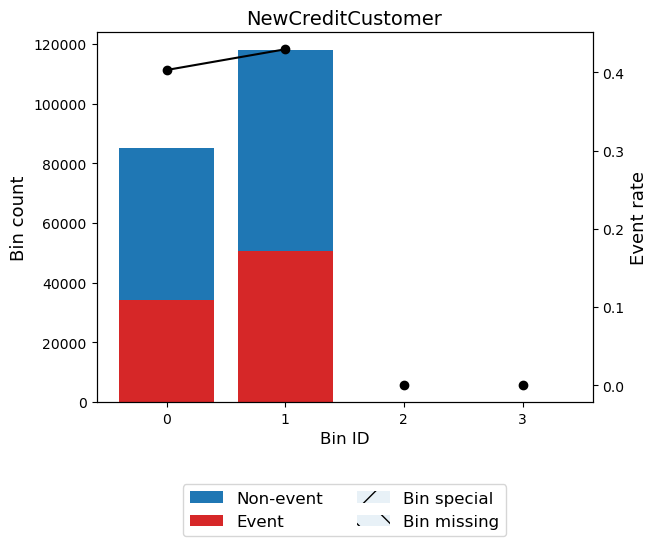

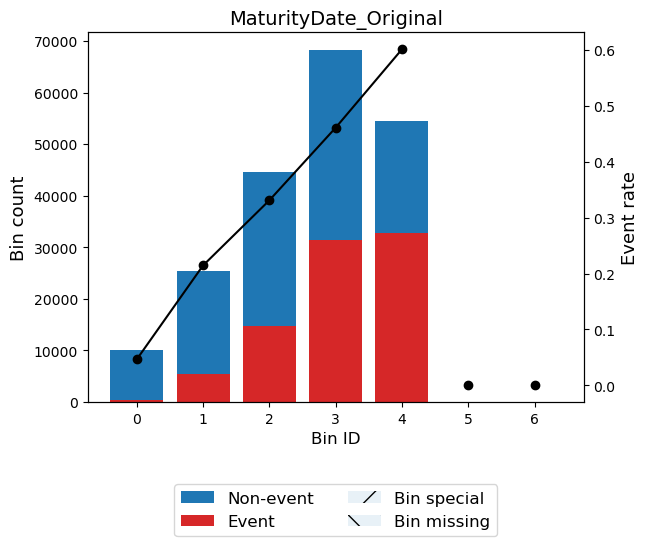

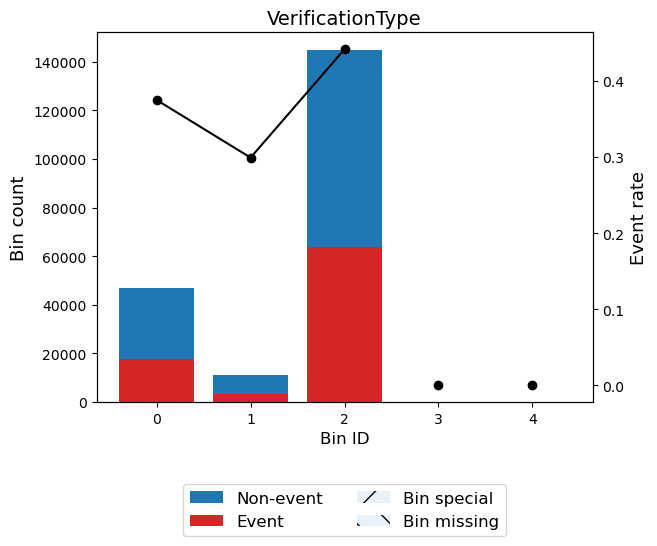

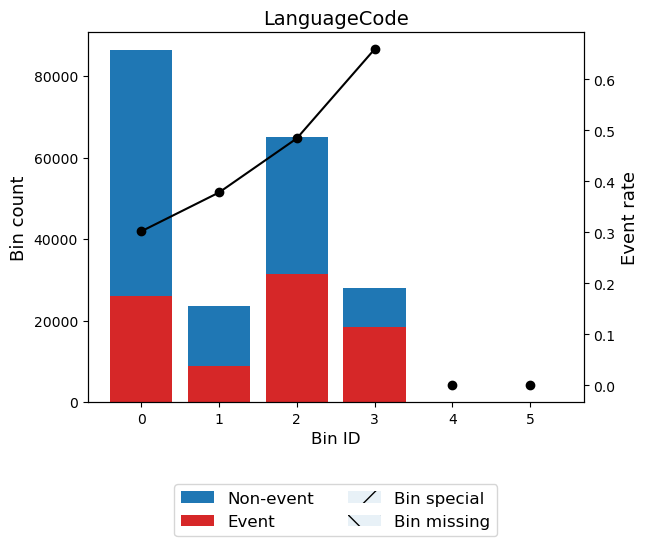

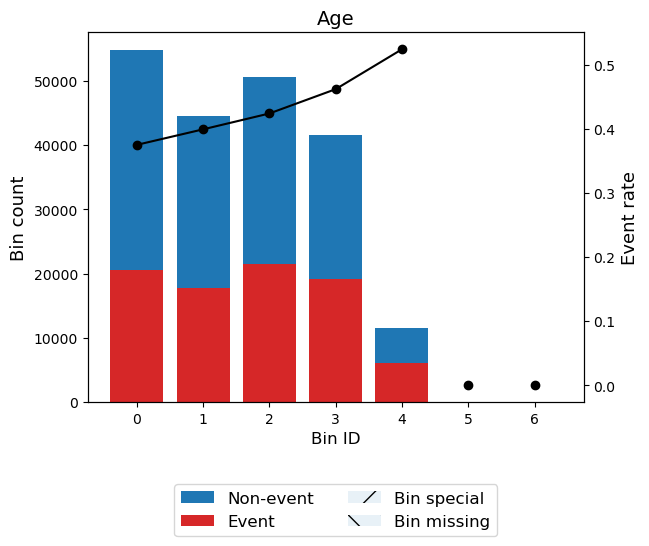

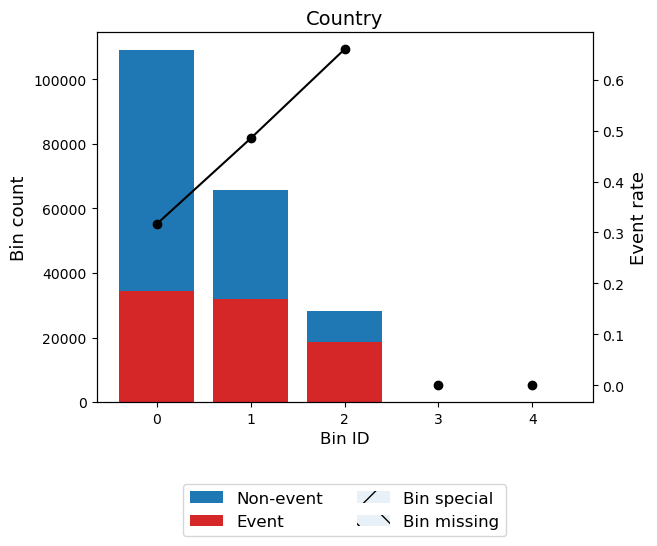

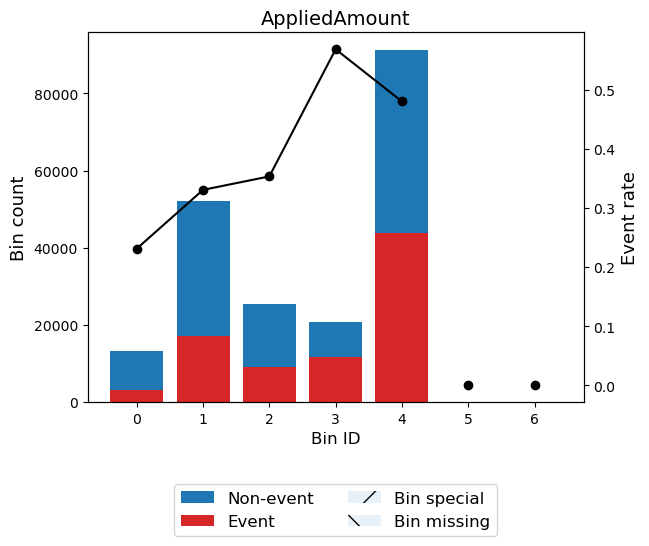

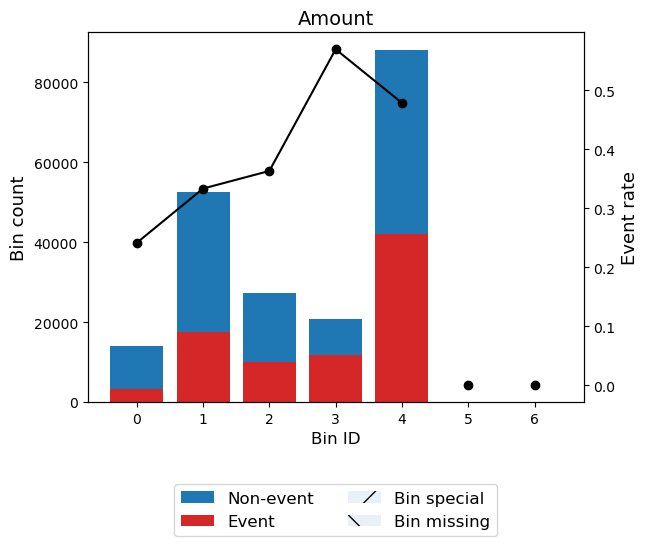

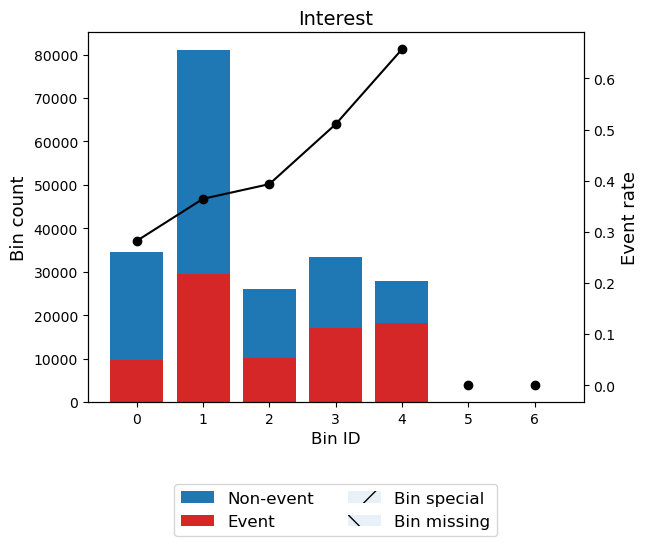

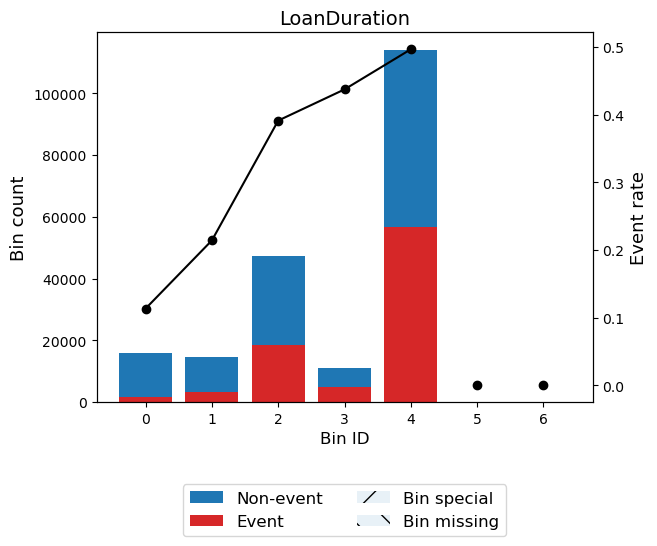

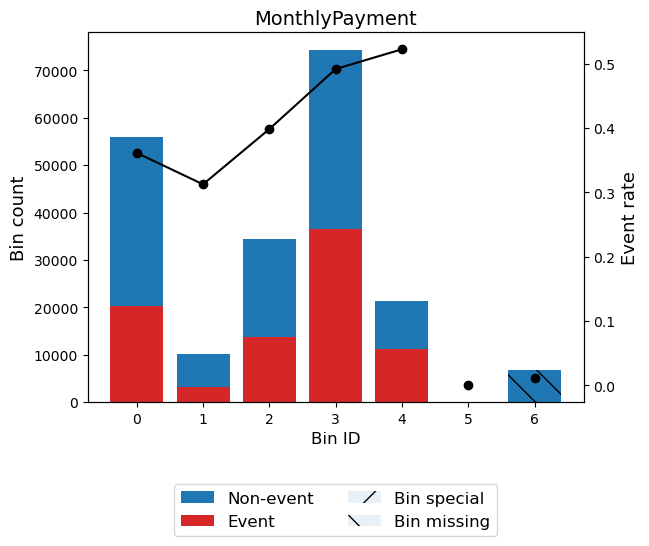

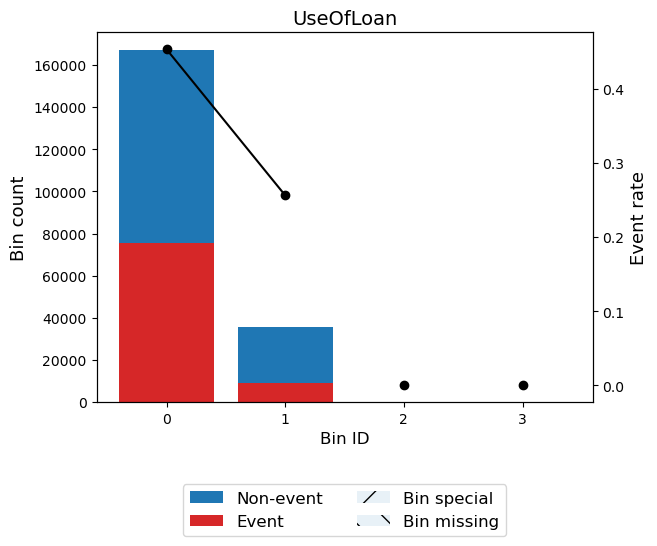

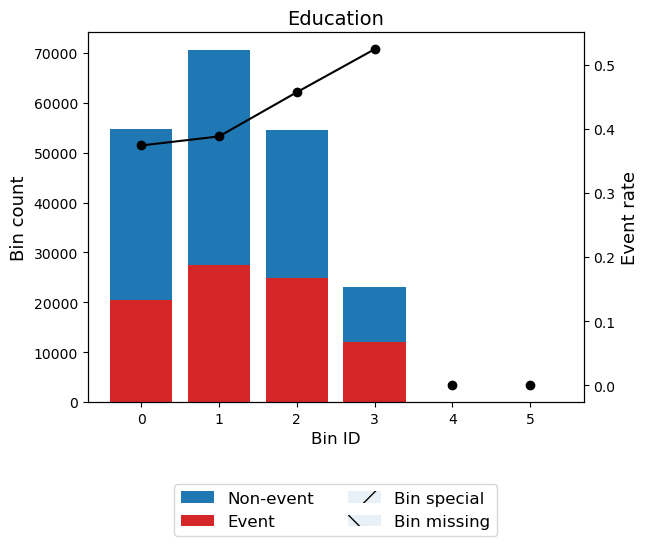

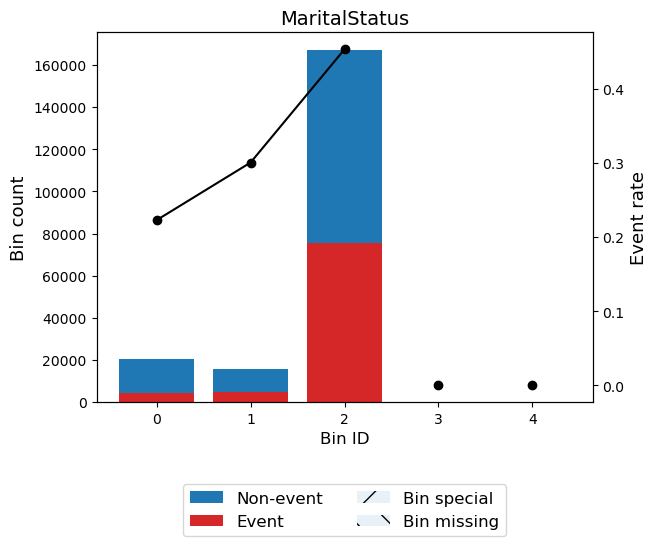

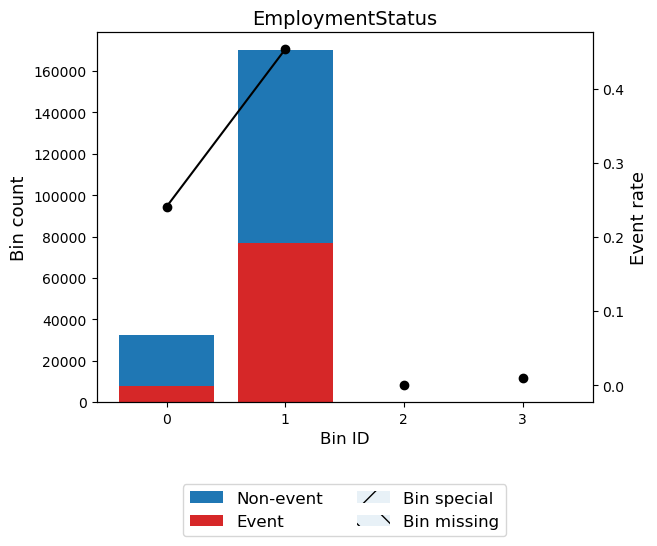

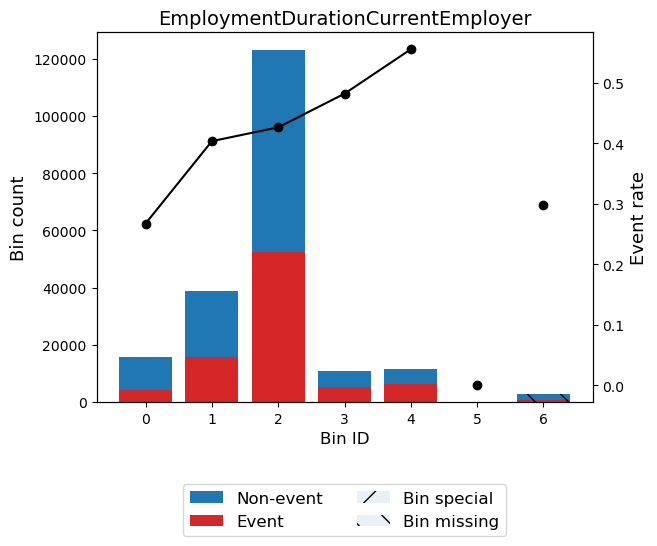

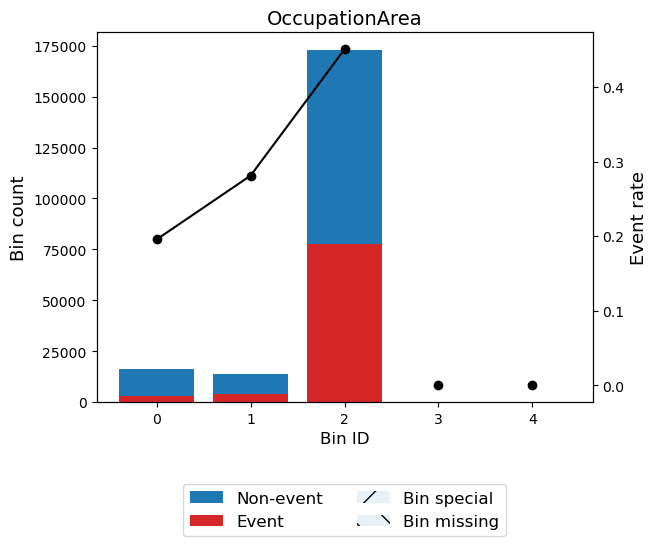

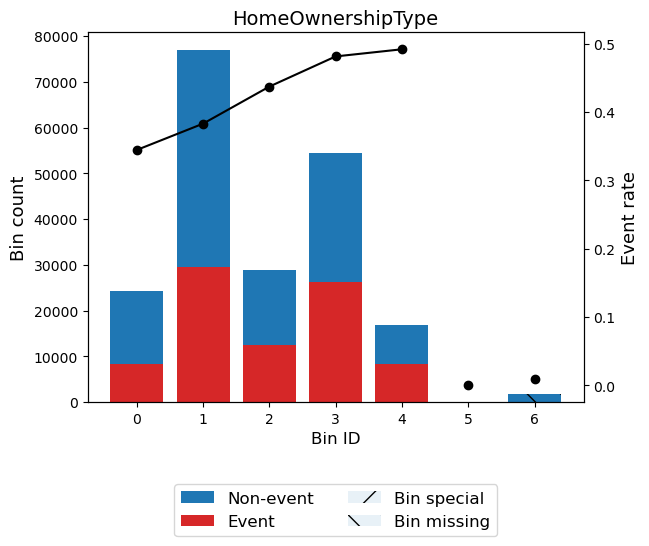

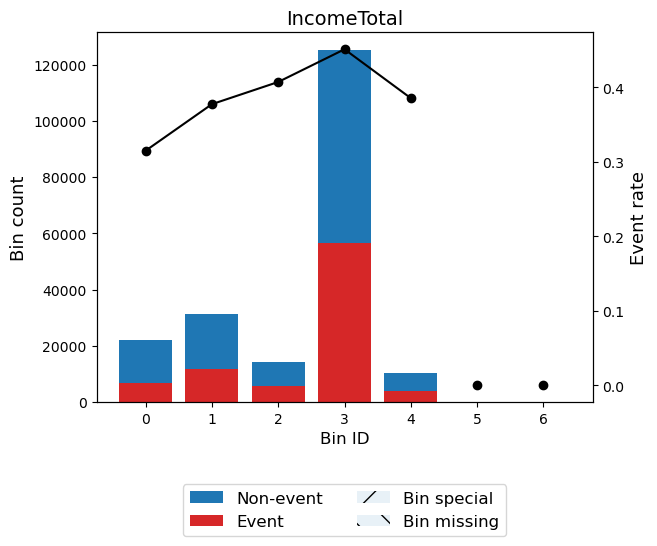

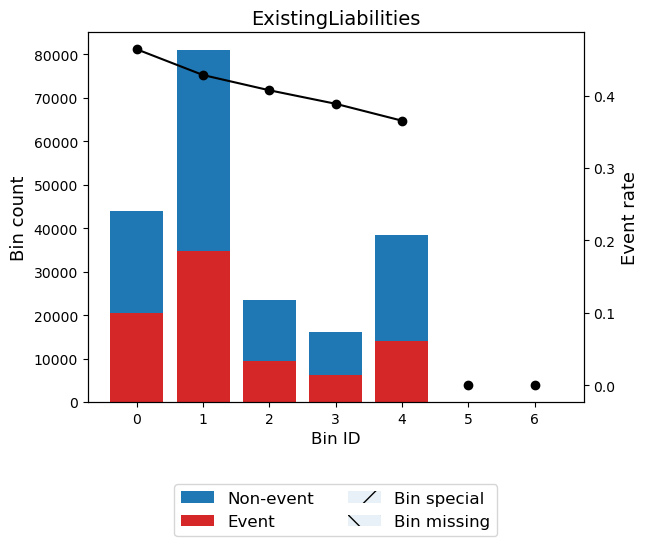

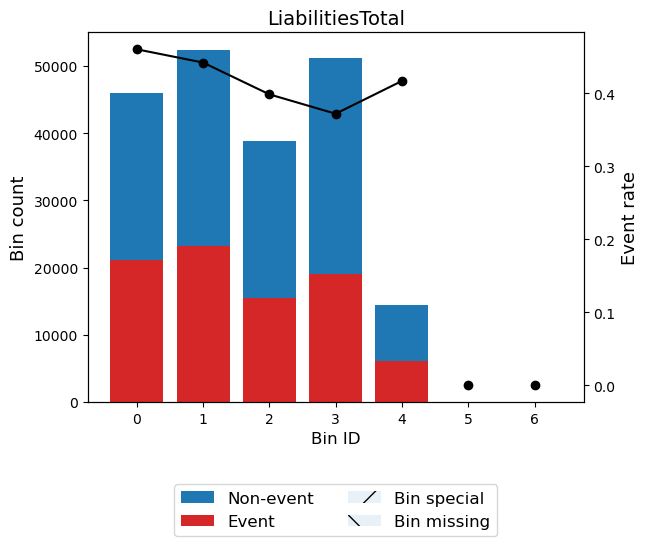

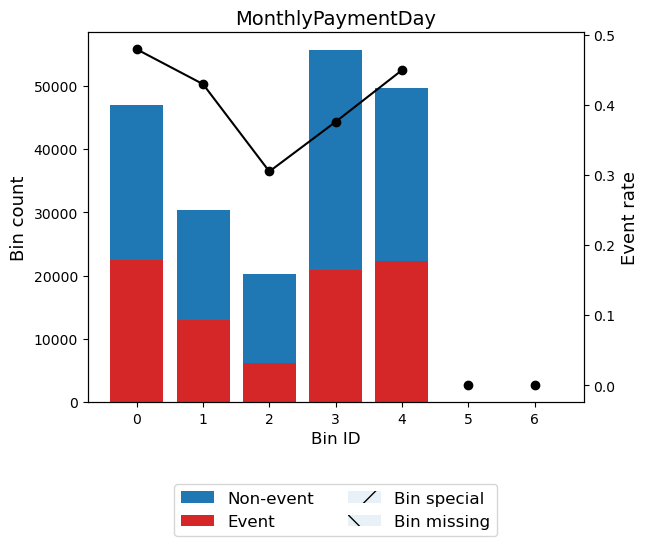

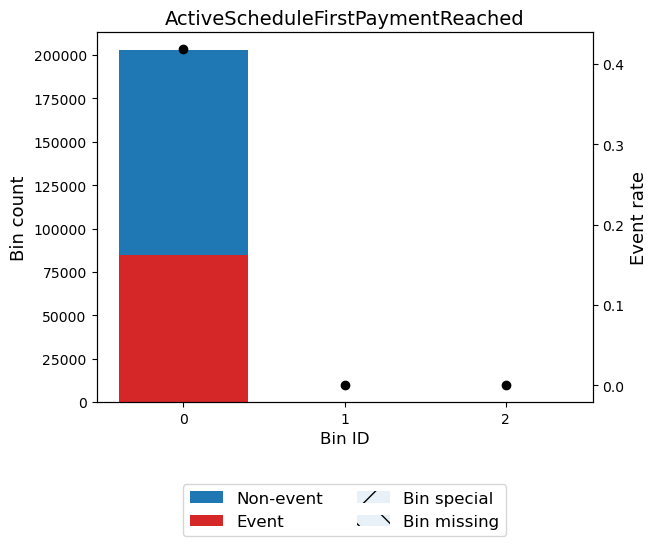

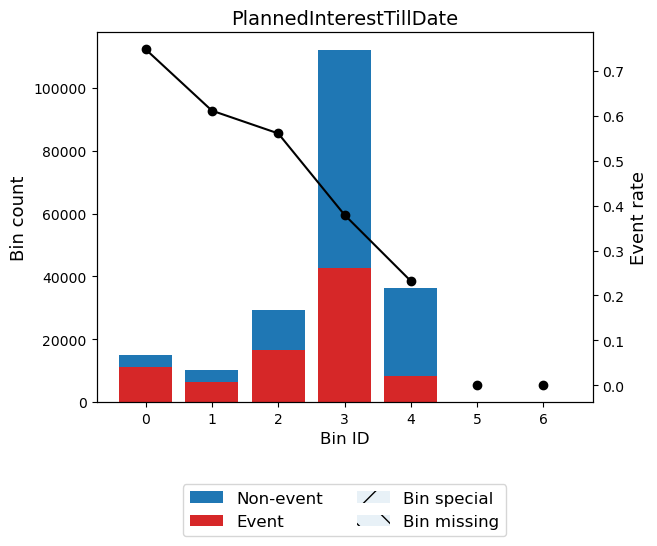

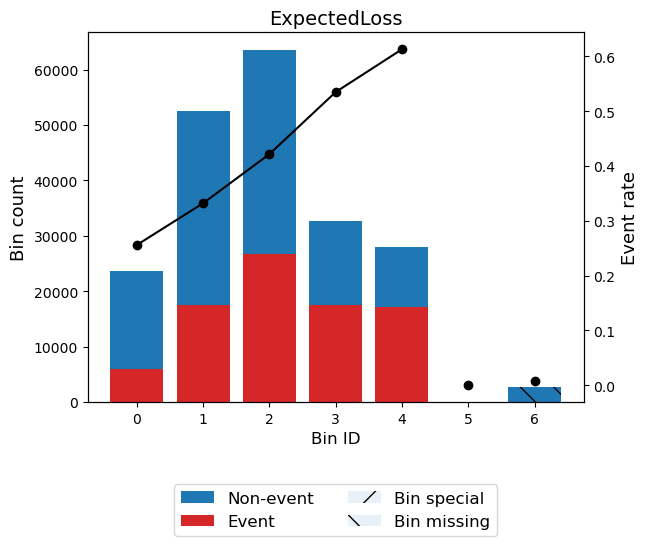

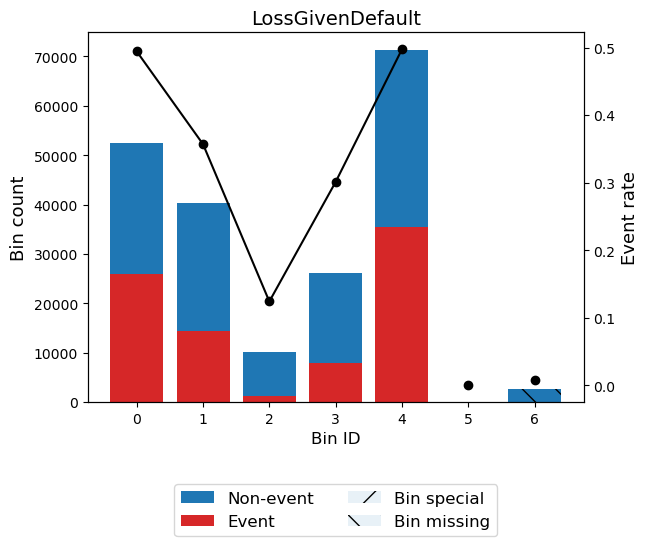

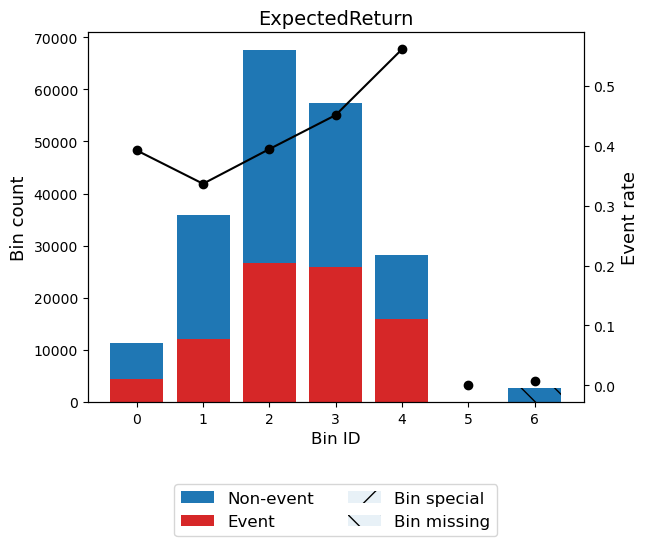

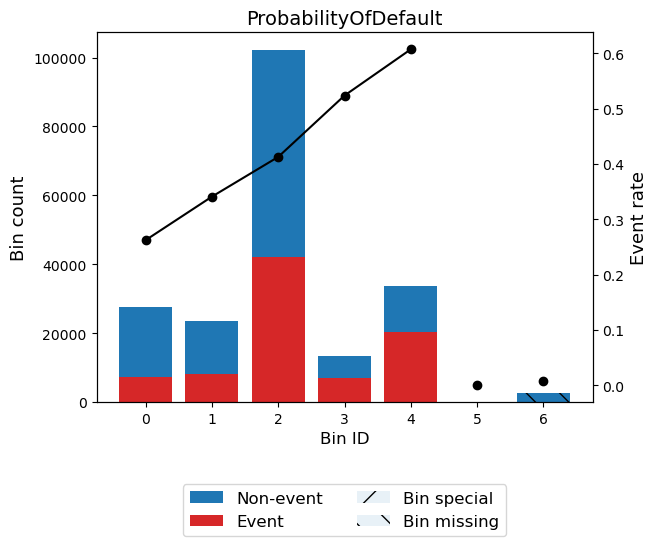

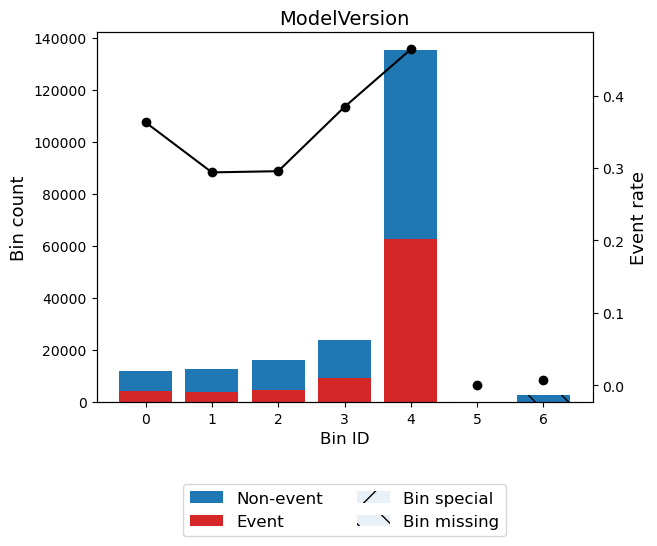

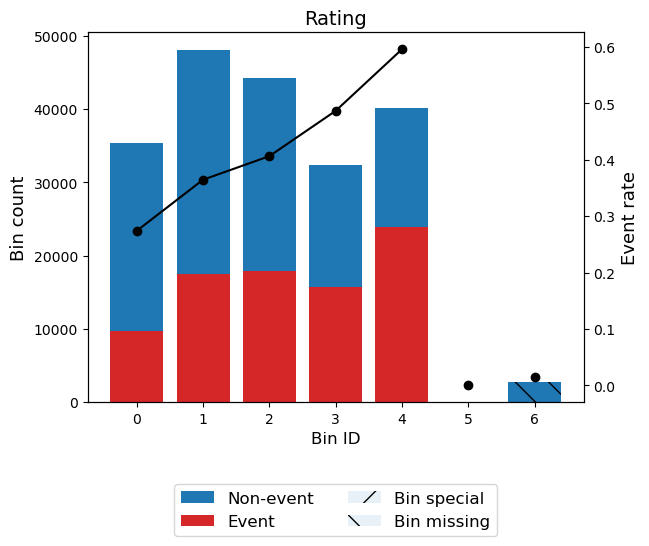

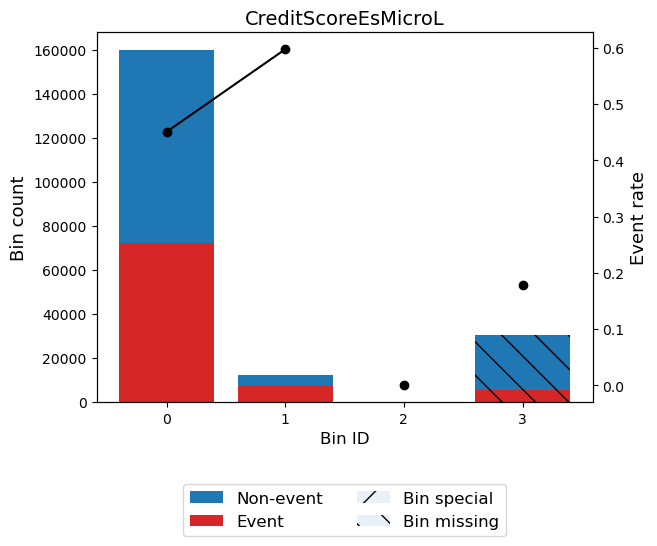

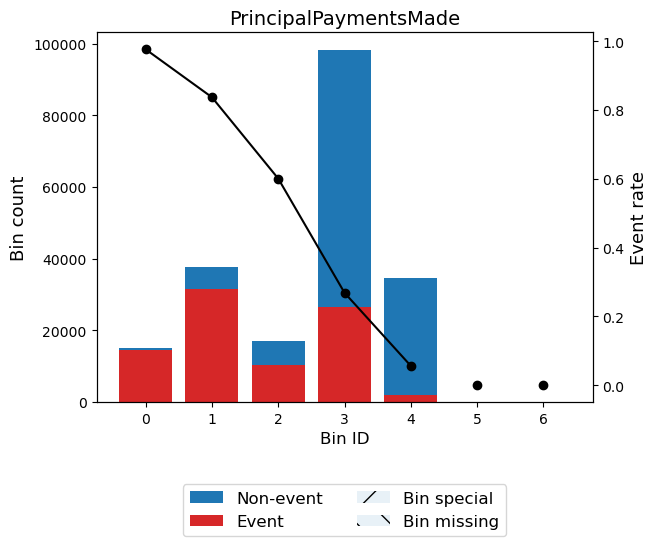

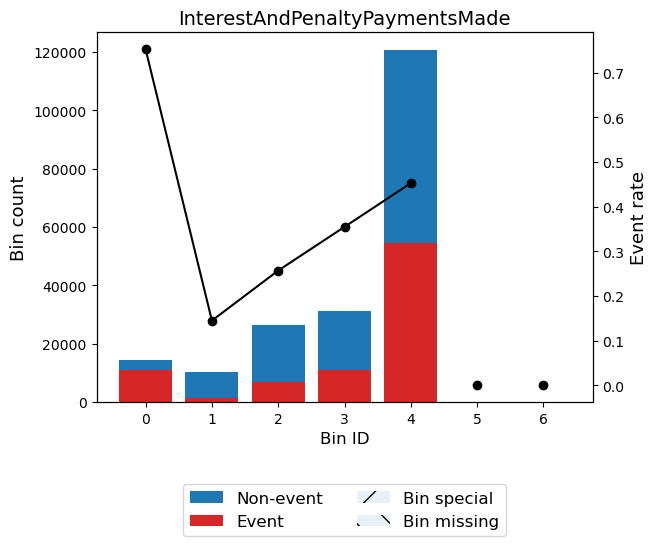

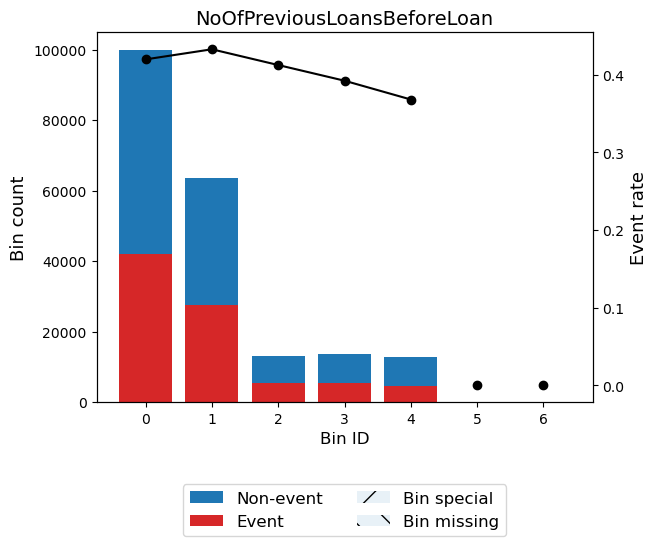

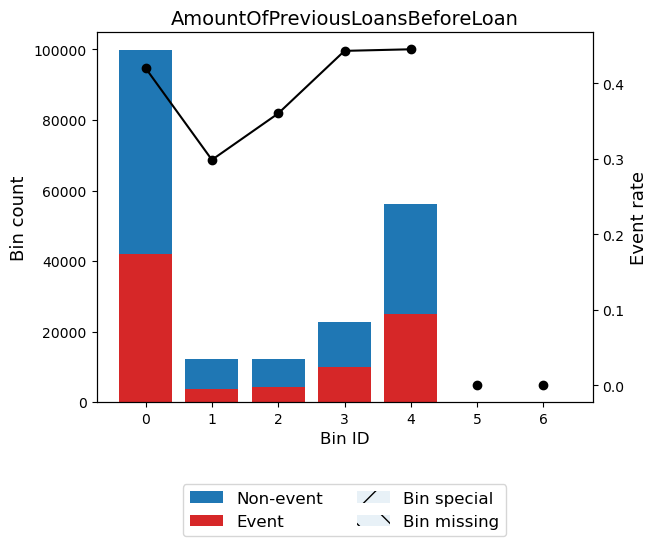

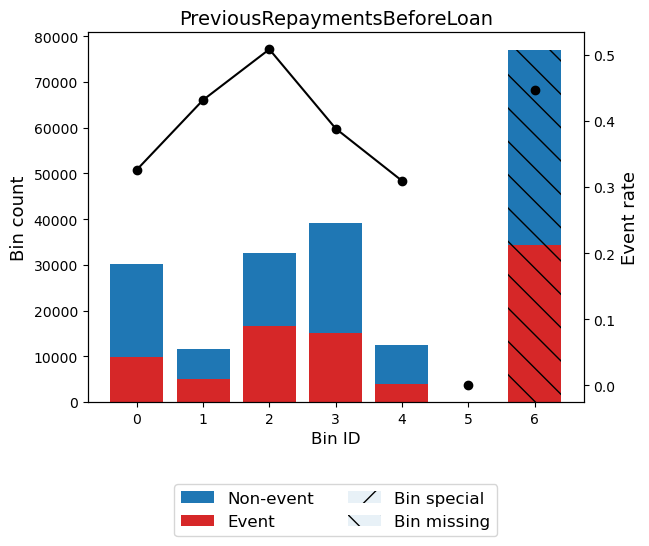

In [31]:
for variable in X:
    optb = binning_process.get_binned_variable(name=variable)
    optb.binning_table.plot(metric = "event_rate")

=> Remove 3 variables,namely: 
-'ActiveScheduleFirstPaymentReached','UseOfLoan' : more than 80% obs fall into 1 or 2 attributes
-'NewCreditCustomer','VerificationType': Good/Bad line not showing monotonic trend clearly (Event_rates are quite simmilar through bins)

In [32]:
list1 = ['ActiveScheduleFirstPaymentReached','UseOfLoan','NewCreditCustomer','VerificationType']

In [33]:
for variable in X:
    optb = binning_process.get_binned_variable(name=variable)
    print(optb.binning_table.build())

            Bin   Count  Count (%)  Non-event  Event  Event rate       WoE  \
0       [False]   84961   0.418746      50718  34243    0.403044   0.06368   
1        [True]  117933   0.581254      67274  50659    0.429557 -0.045462   
2       Special       0   0.000000          0      0    0.000000       0.0   
3       Missing       0   0.000000          0      0    0.000000       0.0   
Totals           202894   1.000000     117992  84902    0.418455             

              IV        JS  
0       0.001689  0.000211  
1       0.001206  0.000151  
2       0.000000  0.000000  
3       0.000000  0.000000  
Totals  0.002894  0.000362  
                                                      Bin   Count  Count (%)  \
0       [2009-04-15, 2015-01-20, 2015-01-19, 2015-01-1...   10157   0.050061   
1       [2021-04-14, 2020-06-12, 2019-04-10, 2017-05-1...   25442   0.125396   
2       [2022-04-08, 2019-10-21, 2017-03-27, 2017-07-0...   44547   0.219558   
3       [2024-01-11, 2026-05-14, 2020

                         Bin   Count  Count (%)  Non-event  Event  Event rate  \
0       [0.0, 2.0, 5.0, 1.0]   20239   0.099752      15730   4509    0.222788   
1                 [3.0, 4.0]   15551   0.076646      10878   4673    0.300495   
2                     [-1.0]  167054   0.823356      91334  75720    0.453267   
3                    Special       0   0.000000          0      0    0.000000   
4                    Missing      50   0.000246         50      0    0.000000   
Totals                        202894   1.000000     117992  84902    0.418455   

             WoE        IV        JS  
0       0.920375  0.073819  0.008915  
1       0.515822  0.019164  0.002369  
2      -0.141638  0.016683  0.002084  
3            0.0  0.000000  0.000000  
4            0.0  0.000000  0.000000  
Totals            0.109666  0.013368  
                         Bin   Count  Count (%)  Non-event  Event  Event rate  \
0       [0.0, 5.0, 3.0, 2.0]   32586   0.160606      24742   7844    0.240717 

                 Bin   Count  Count (%)  Non-event  Event  Event rate  \
0       (-inf, 0.06)   11267   0.055531       6846   4421    0.392385   
1       [0.06, 0.09)   35867   0.176777      23792  12075    0.336660   
2       [0.09, 0.13)   67529   0.332829      40883  26646    0.394586   
3       [0.13, 0.19)   57336   0.282591      31456  25880    0.451374   
4        [0.19, inf)   28257   0.139270      12396  15861    0.561312   
5            Special       0   0.000000          0      0    0.000000   
6            Missing    2638   0.013002       2619     19    0.007202   
Totals                202894   1.000000     117992  84902    0.418455   

             WoE        IV        JS  
0       0.108179  0.000644  0.000080  
1       0.349093  0.020742  0.002580  
2       0.098956  0.003230  0.000404  
3         -0.134  0.005123  0.000640  
4      -0.575609  0.047060  0.005803  
5            0.0  0.000000  0.000000  
6        4.59699  0.101008  0.007143  
Totals            0.177807  0.

In [34]:
optb = binning_process.get_binned_variable(name='PrincipalPaymentsMade')
optb.binning_table.build()

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 31.92)",14968,0.073773,353,14615,0.976416,-4.052455,0.685464,0.053125
1,"[31.92, 309.96)",37805,0.186329,6161,31644,0.837032,-1.965429,0.629913,0.068099
2,"[309.96, 499.74)",17109,0.084325,6831,10278,0.600736,-0.737654,0.046593,0.005696
3,"[499.74, 2999.52)",98248,0.484233,71842,26406,0.268769,0.671759,0.200086,0.024551
4,"[2999.52, inf)",34764,0.171341,32805,1959,0.056351,2.489028,0.634587,0.063635
5,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
6,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,202894,1.000000,117992,84902,0.418455,,2.196643,0.215106


2.2. Accuracy ratio(AR) and IV (information value)

In [48]:
#Plot WOE trend for each variable

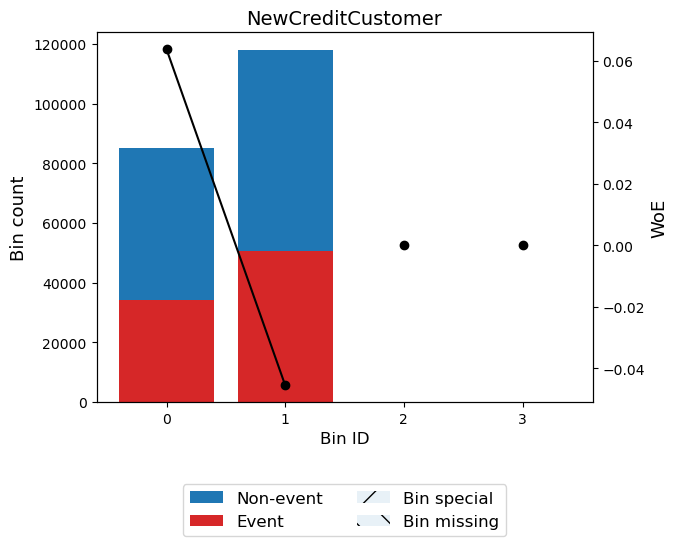

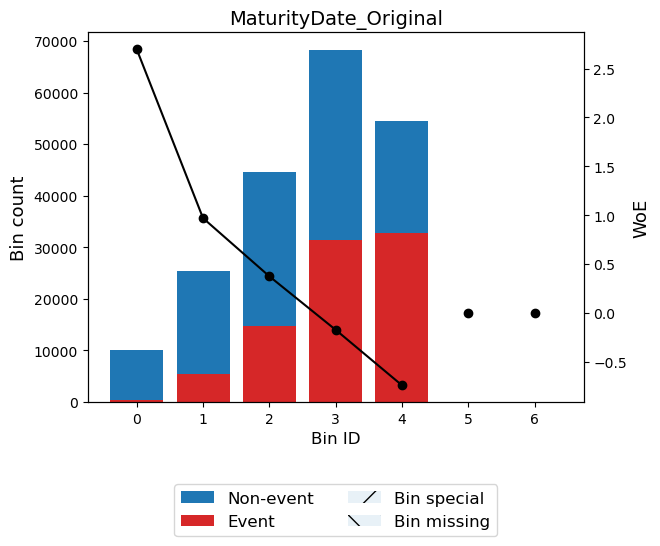

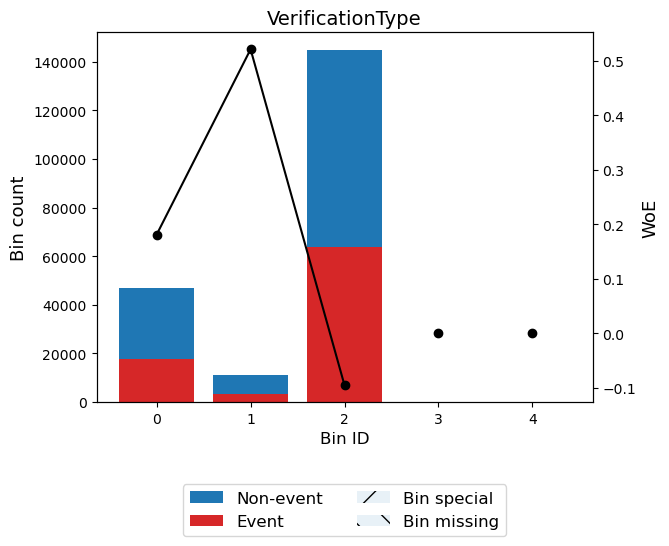

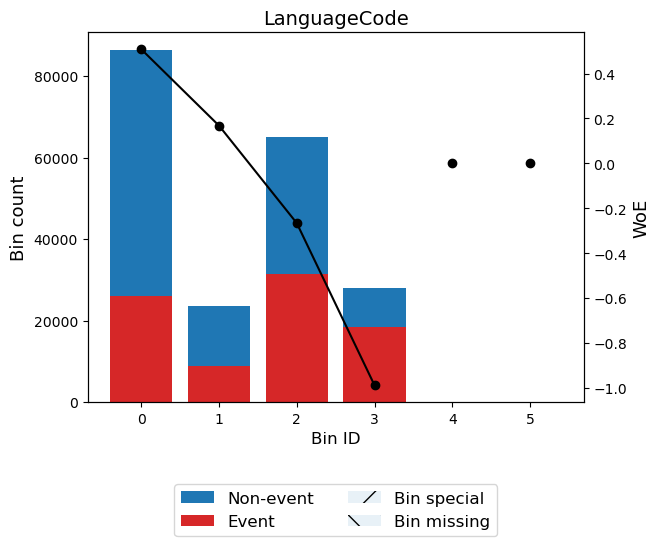

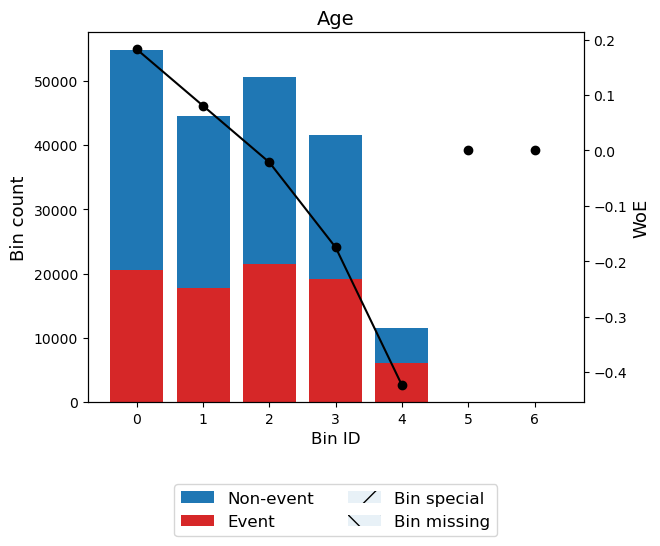

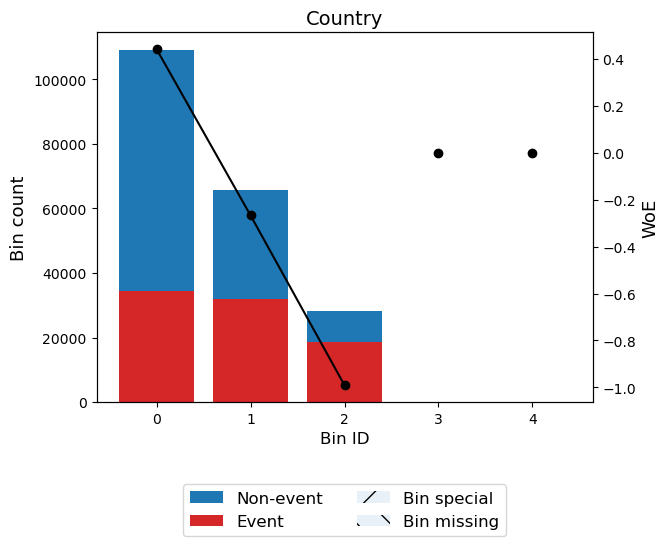

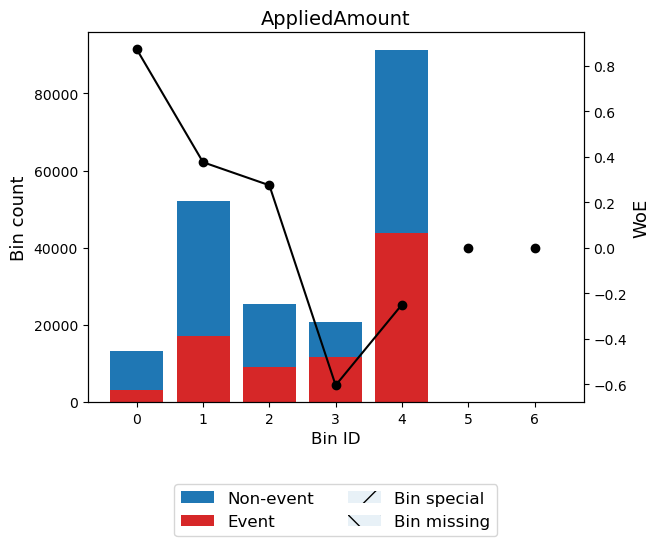

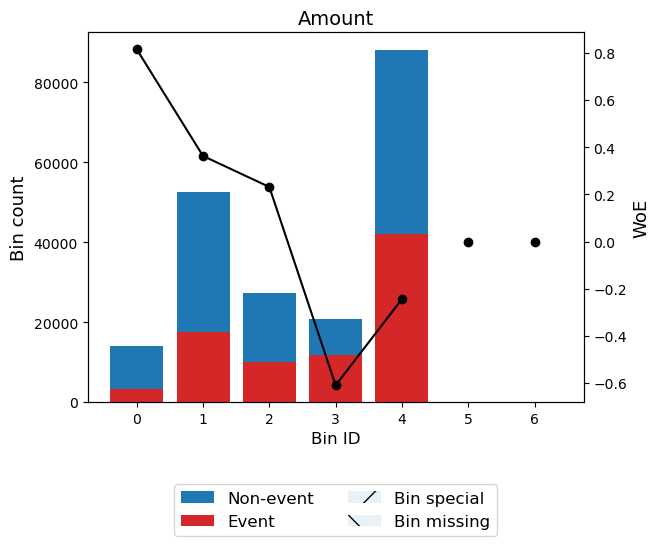

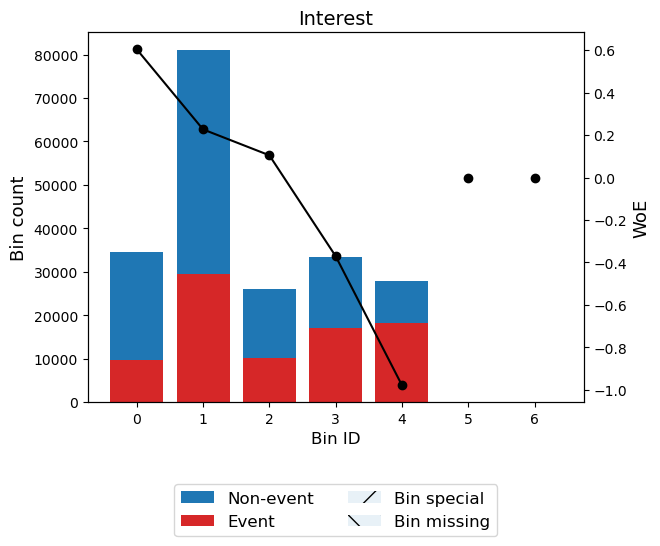

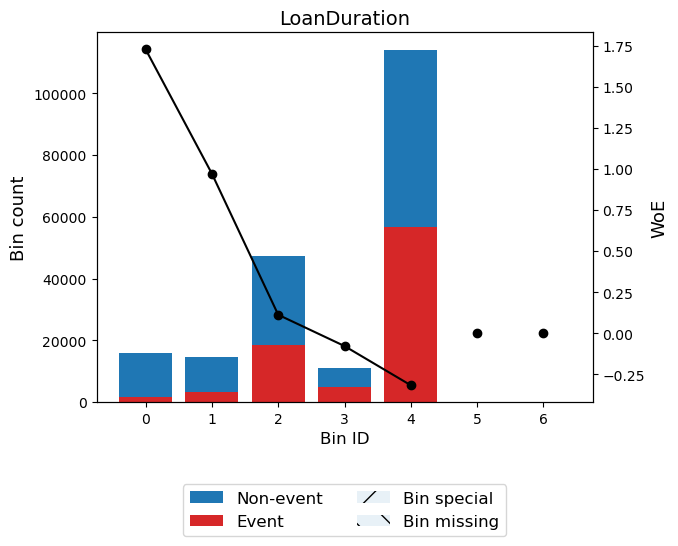

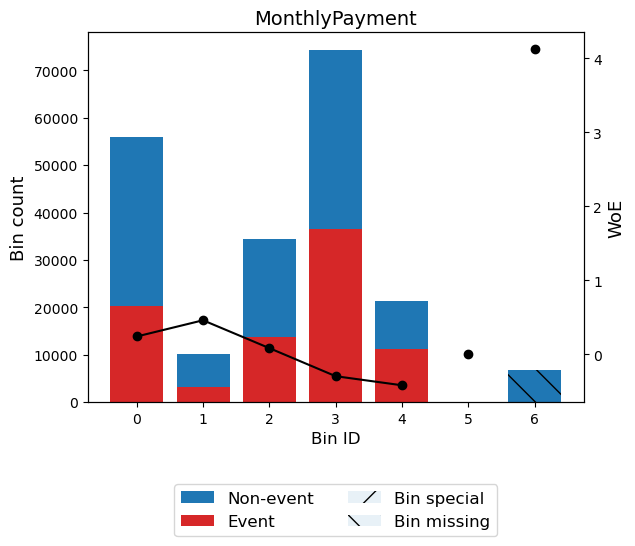

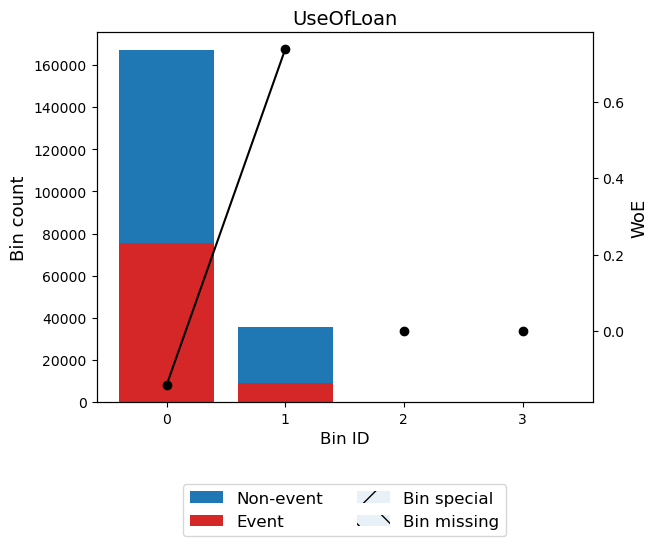

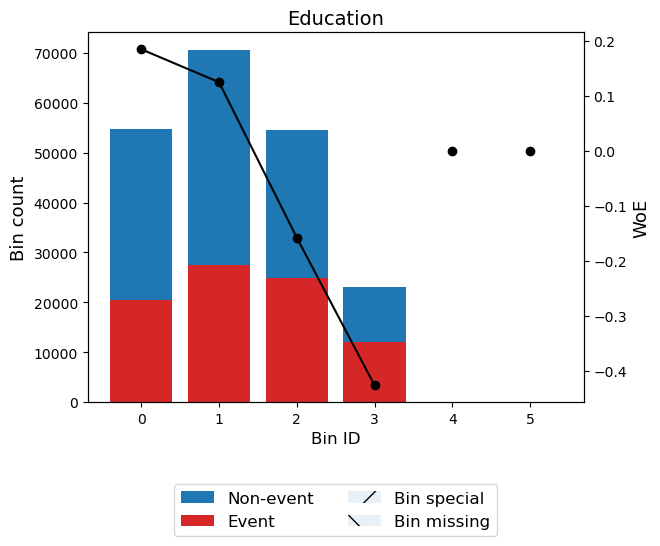

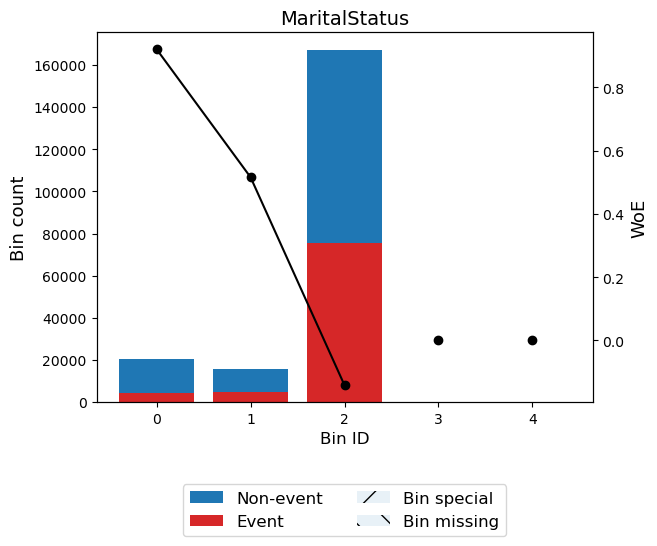

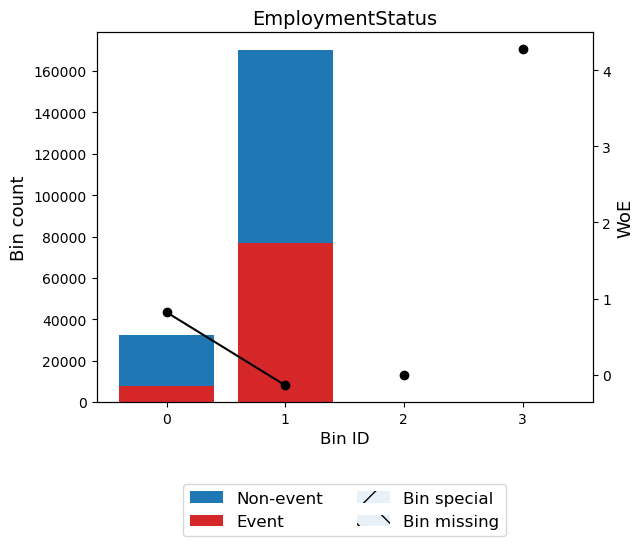

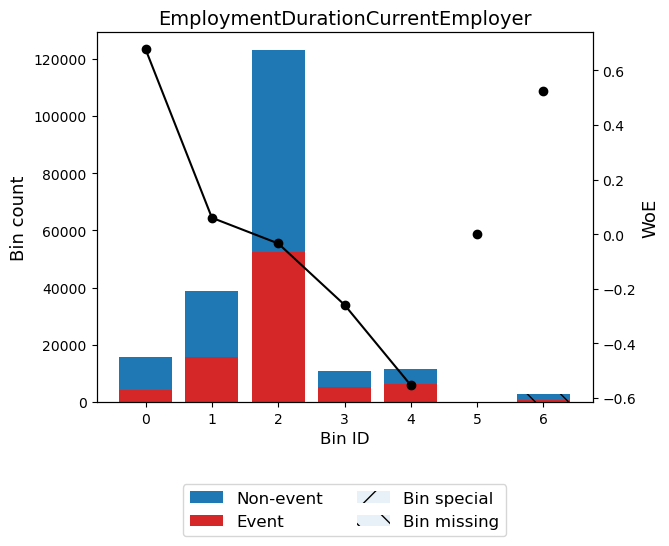

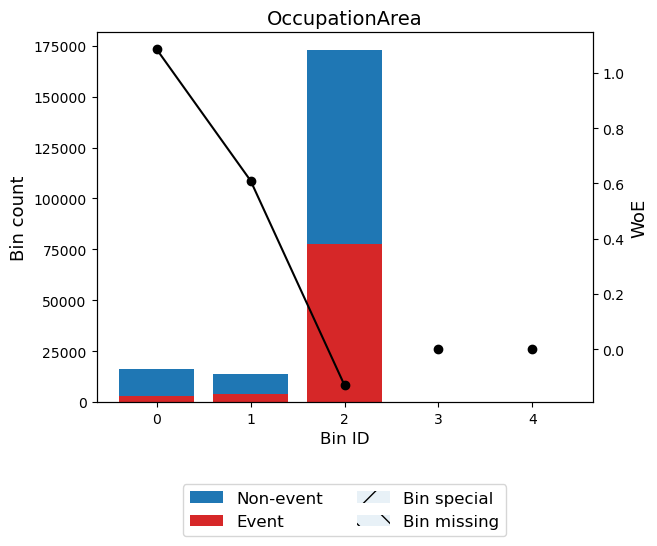

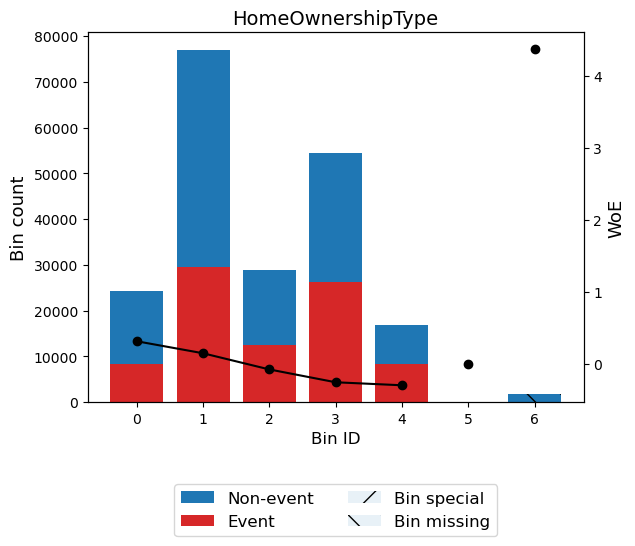

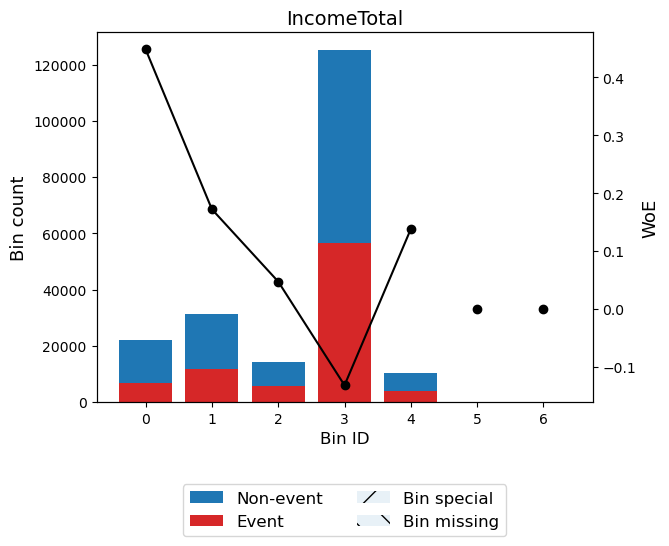

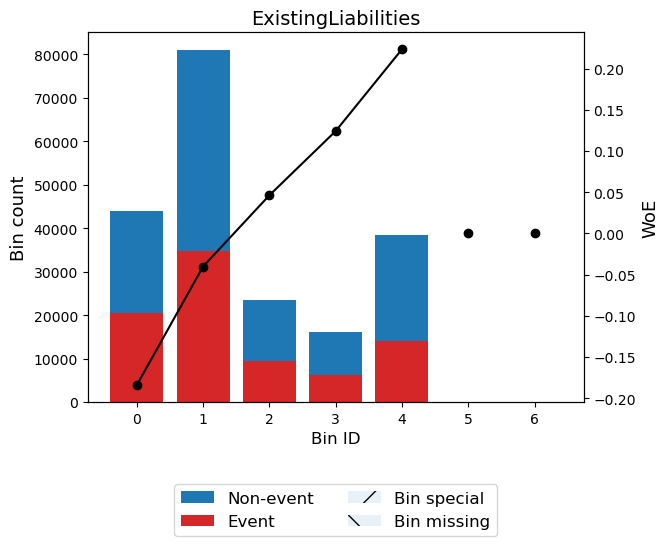

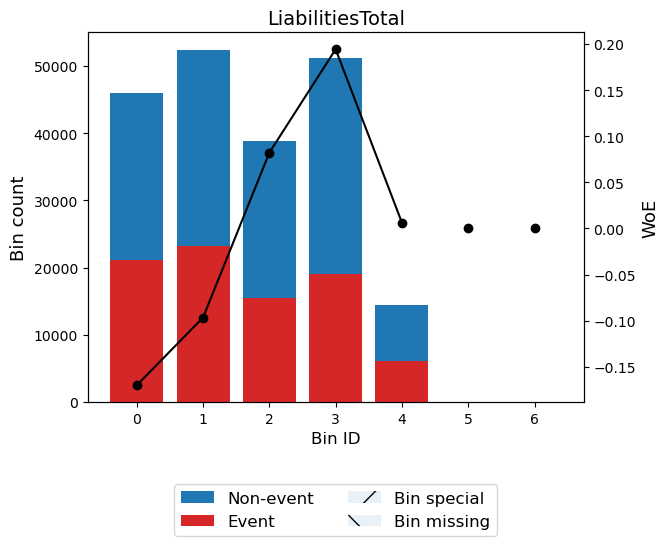

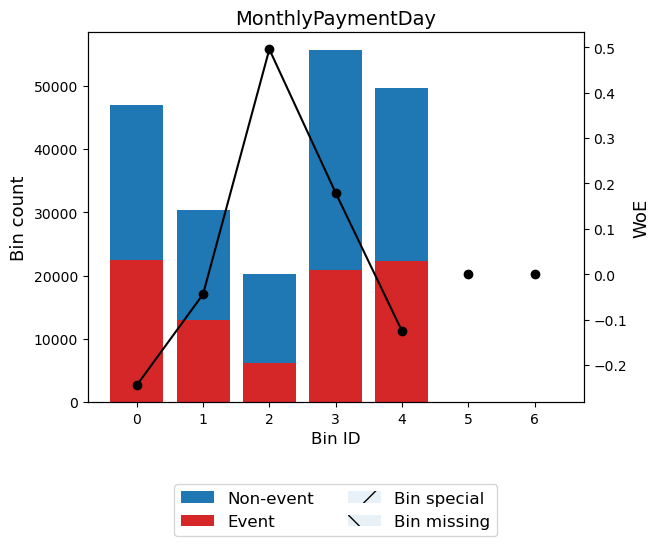

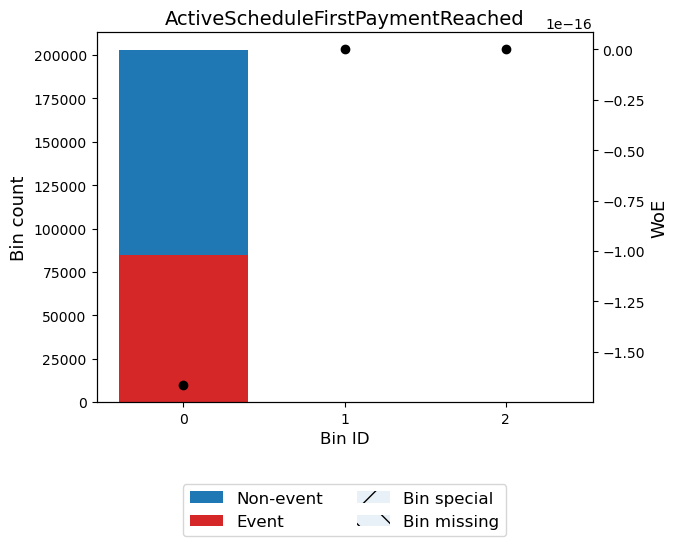

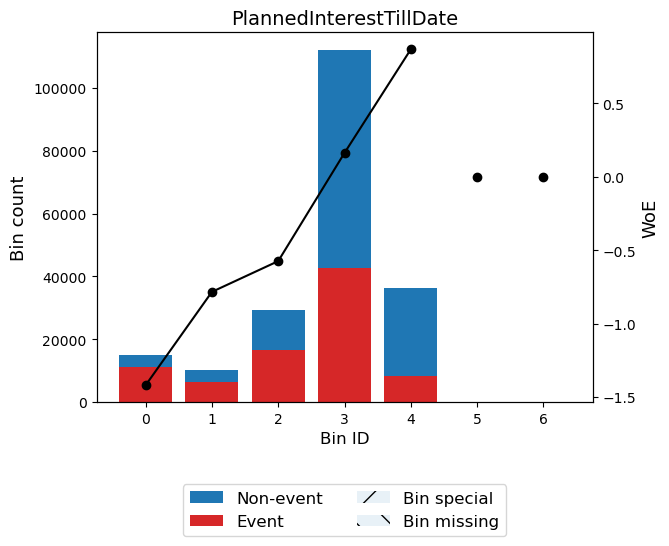

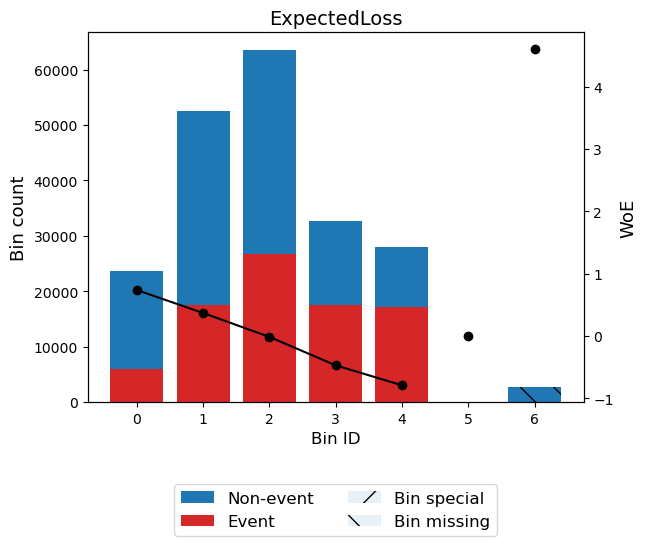

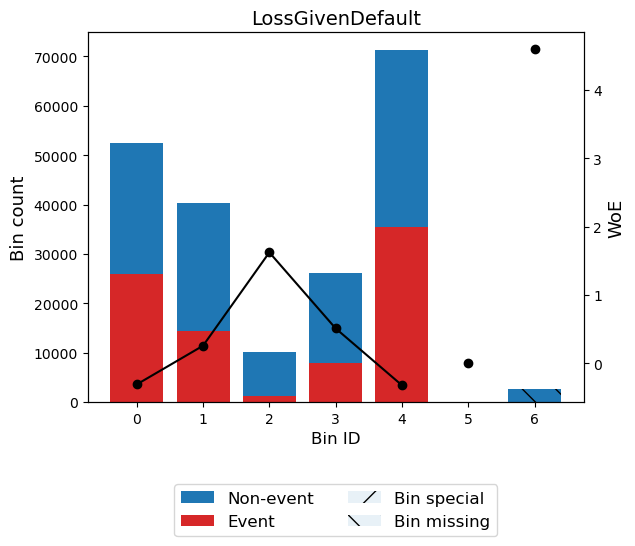

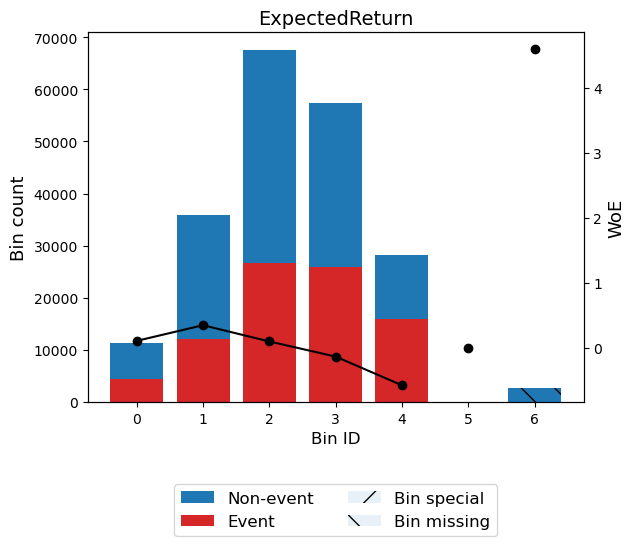

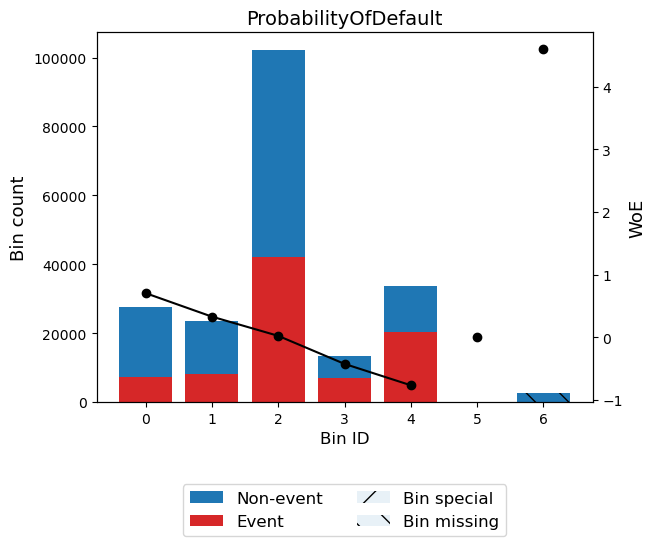

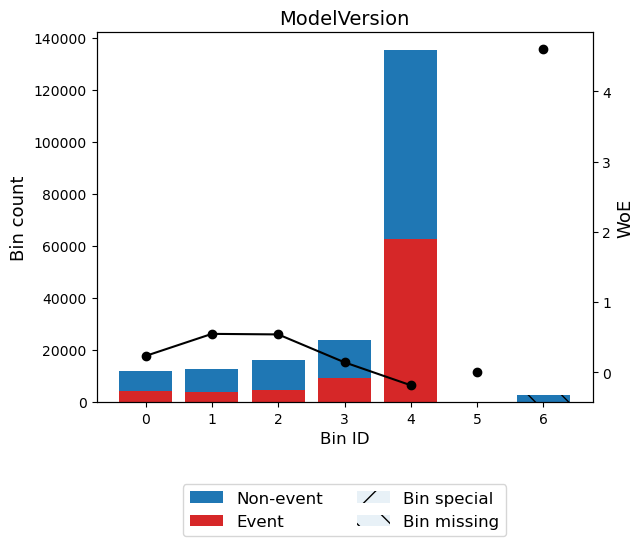

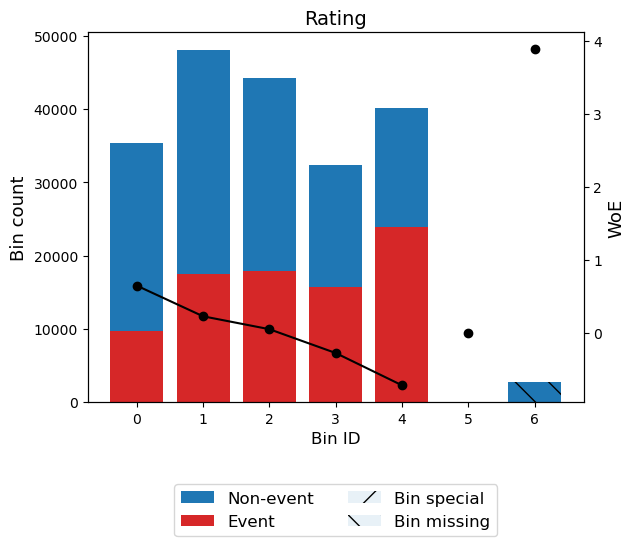

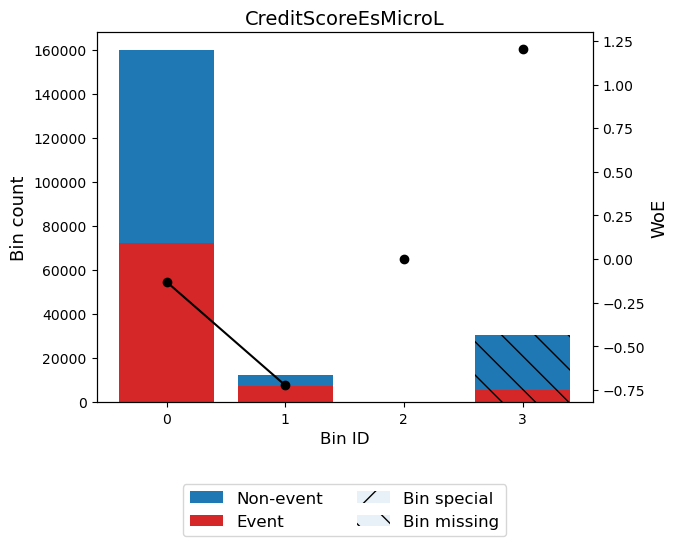

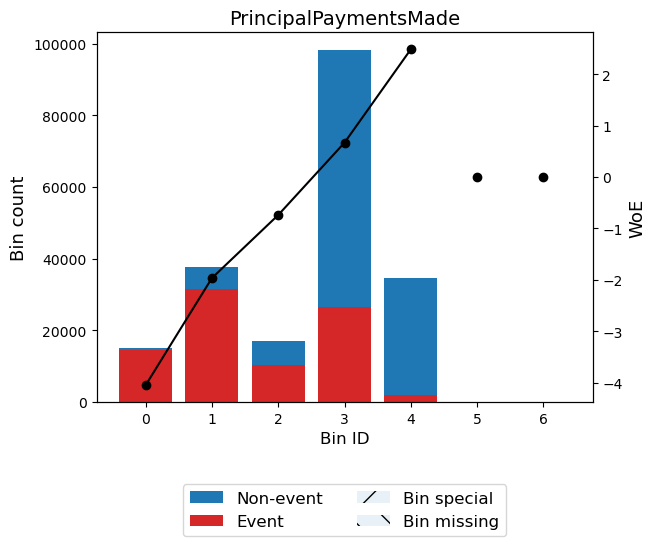

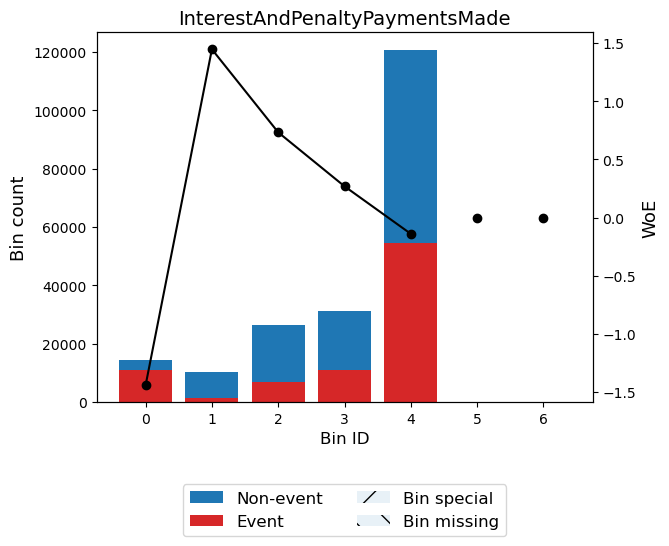

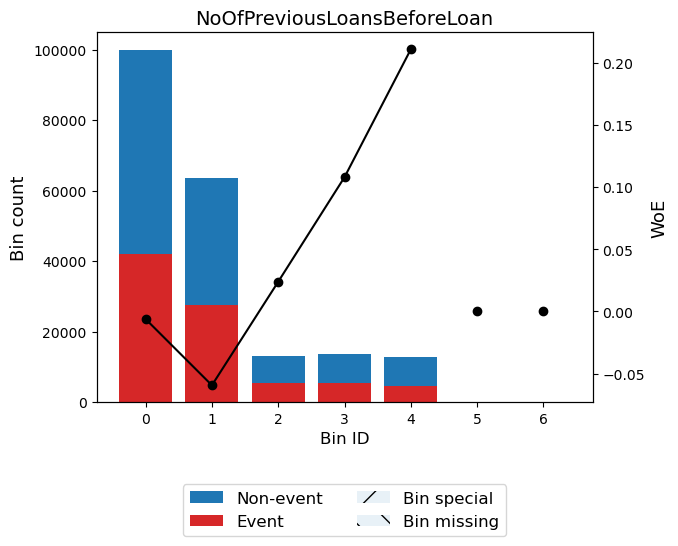

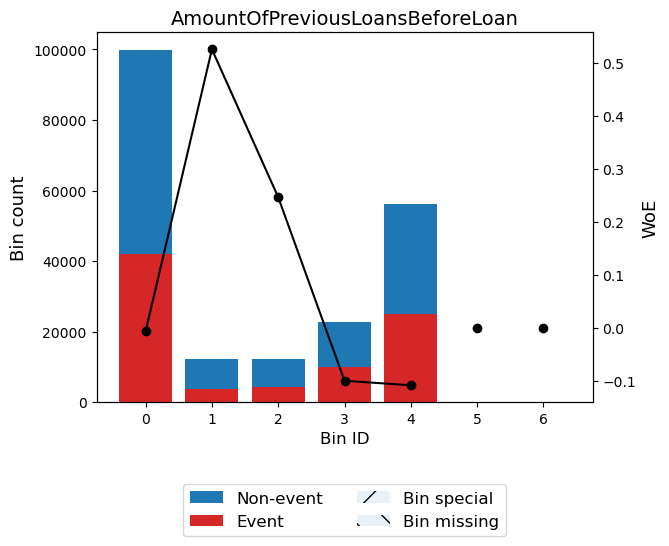

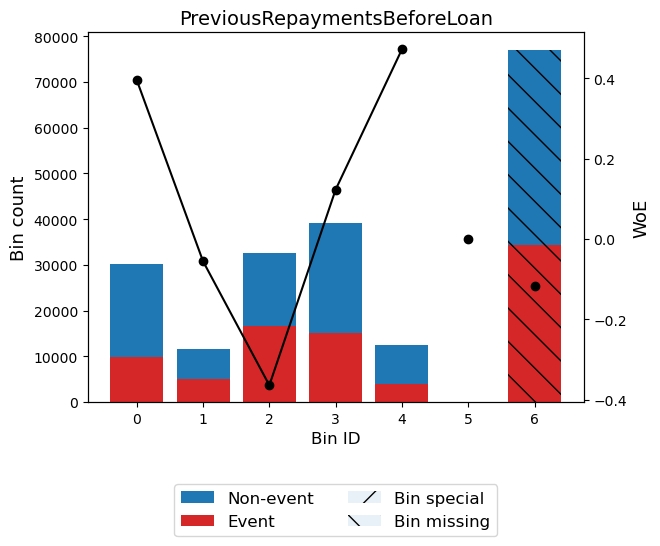

In [35]:
for variable in X:
    optb = binning_process.get_binned_variable(name=variable)
    optb.binning_table.plot(metric = "woe")

In [36]:
df5 = binning_process.summary()
df5

,name,dtype,status,selected,n_bins,iv,js,gini,quality_score
0,NewCreditCustomer,categorical,OPTIMAL,True,2,0.002894,0.000362,0.026519,0.007826
1,MaturityDate_Original,categorical,OPTIMAL,True,5,0.497552,0.055519,0.343141,0.820984
2,VerificationType,numerical,OPTIMAL,True,3,0.027863,0.003462,0.072365,0.062825
3,LanguageCode,categorical,OPTIMAL,True,4,0.264462,0.032258,0.270027,0.723024
4,Age,numerical,OPTIMAL,True,5,0.027128,0.003379,0.08868,0.101514
5,Country,categorical,OPTIMAL,True,3,0.258926,0.031594,0.257595,0.63898
6,AppliedAmount,numerical,OPTIMAL,True,5,0.154889,0.019082,0.207707,0.489048
7,Amount,numerical,OPTIMAL,True,5,0.145912,0.017996,0.203578,0.470913
8,Interest,numerical,OPTIMAL,True,5,0.233608,0.028445,0.249431,0.714509
9,LoanDuration,numerical,OPTIMAL,True,5,0.288902,0.033511,0.227852,0.662656


In [37]:
df6 = df5[(df5['gini'] < 0.1) | (df5['iv'] < 0.1) | (df5['iv'] > 0.5) ]
df6

,name,dtype,status,selected,n_bins,iv,js,gini,quality_score
0,NewCreditCustomer,categorical,OPTIMAL,True,2,0.002894,0.000362,0.026519,0.007826
2,VerificationType,numerical,OPTIMAL,True,3,0.027863,0.003462,0.072365,0.062825
4,Age,numerical,OPTIMAL,True,5,0.027128,0.003379,0.08868,0.101514
12,Education,categorical,OPTIMAL,True,4,0.042312,0.005266,0.106471,0.151697
15,EmploymentDurationCurrentEmployer,categorical,OPTIMAL,True,5,0.058998,0.007264,0.10281,0.165424
18,IncomeTotal,numerical,OPTIMAL,True,5,0.037122,0.004617,0.092936,0.103555
19,ExistingLiabilities,numerical,OPTIMAL,True,5,0.018792,0.002345,0.07502,0.067343
20,LiabilitiesTotal,numerical,OPTIMAL,True,5,0.019711,0.002461,0.078175,0.074309
21,MonthlyPaymentDay,numerical,OPTIMAL,True,5,0.050103,0.006227,0.120074,0.188192
22,ActiveScheduleFirstPaymentReached,categorical,OPTIMAL,True,1,0.0,0.0,0,0.0


These are characteristics to remove from model building sample due to unsatisfactory IV and AR (i.e gini coefficient);

In [38]:
list2 = df6['name'].values

In [39]:
list1 = np.array(list1)

In [40]:
list3 = np.concatenate((list1, list2))
list3

array(['ActiveScheduleFirstPaymentReached', 'UseOfLoan',
       'NewCreditCustomer', 'VerificationType', 'NewCreditCustomer',
       'VerificationType', 'Age', 'Education',
       'EmploymentDurationCurrentEmployer', 'IncomeTotal',
       'ExistingLiabilities', 'LiabilitiesTotal', 'MonthlyPaymentDay',
       'ActiveScheduleFirstPaymentReached', 'PrincipalPaymentsMade',
       'NoOfPreviousLoansBeforeLoan', 'AmountOfPreviousLoansBeforeLoan',
       'PreviousRepaymentsBeforeLoan'], dtype=object)

=> List3: variables to be discarded

#As can be seen, some variables chosen for latter stages have monotonic WOE trend, which is expected to serve logistic regression. The remainings have an U-shaped curve with respect to WOE though, and this trend may be reflecting actual
behavior. For example, at first very low loan_amount is higher risk (negative WOE), then the risk decreases up to a point, and finally risk starts increasing as loan_amount increases. This relationship should be kept, as long as it can be explained.

In [42]:
dulieuktl1 = dulieuktl1.drop(list3, axis=1)

In [41]:
dulieuktl1 = binning_process.transform(dulieuktl1, metric = "woe")

In [43]:
dulieuktl1['y'] = y

In [44]:
dulieuktl1

,MaturityDate_Original,LanguageCode,Country,AppliedAmount,Amount,Interest,LoanDuration,MonthlyPayment,MaritalStatus,EmploymentStatus,...,PlannedInterestTillDate,ExpectedLoss,LossGivenDefault,ExpectedReturn,ProbabilityOfDefault,ModelVersion,Rating,CreditScoreEsMicroL,InterestAndPenaltyPaymentsMade,y
0,0.969664,0.508363,0.441145,-0.604556,-0.609600,0.226606,-0.316008,0.082677,0.920375,-0.140515,...,0.162067,0.369427,1.625258,-0.134000,0.022571,0.539295,0.226387,0.000000,-0.139747,0
1,0.374654,0.508363,0.441145,-0.249535,-0.243959,0.603876,-0.316008,0.082677,0.920375,0.819634,...,0.162067,0.738008,0.512968,-0.134000,0.704368,0.547128,0.645980,0.000000,-0.139747,0
2,0.374654,0.508363,0.441145,-0.249535,-0.243959,0.603876,-0.316008,-0.419314,0.515822,0.819634,...,0.867074,0.738008,1.625258,0.098956,0.704368,0.539295,0.645980,0.000000,-0.139747,0
3,-0.172704,-0.988582,-0.991125,0.275175,0.231660,-0.370392,-0.316008,0.082677,0.920375,0.819634,...,0.162067,-0.469621,-0.319133,-0.134000,0.022571,0.547128,-0.717662,-0.724098,-0.139747,1
4,-0.739967,-0.988582,-0.991125,0.275175,0.231660,-0.978447,-0.077508,-0.296480,0.515822,-0.140515,...,0.162067,-0.789779,-0.319133,0.098956,-0.766418,0.539295,-0.717662,-0.724098,-1.441130,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202889,-0.172704,-0.988582,-0.991125,0.275175,0.231660,-0.978447,-0.316008,0.082677,0.515822,0.819634,...,-0.574529,-0.789779,-0.319133,-0.134000,-0.766418,0.539295,-0.717662,-0.724098,-0.139747,0
202890,0.374654,0.167956,0.441145,-0.249535,-0.243959,0.226606,-0.316008,0.082677,0.920375,0.819634,...,0.162067,0.369427,0.512968,-0.134000,0.704368,0.547128,0.226387,0.000000,-0.139747,0
202891,0.969664,0.508363,0.441145,0.275175,0.231660,0.603876,-0.077508,0.240091,0.920375,-0.140515,...,-0.574529,0.738008,0.512968,-0.134000,0.704368,0.547128,0.645980,0.000000,-0.139747,0
202892,2.696688,-0.266163,-0.267300,-0.249535,-0.243959,0.226606,-0.316008,-0.296480,-0.141638,-0.140515,...,0.867074,0.369427,-0.319133,0.349093,0.329255,0.233093,0.226387,-0.130992,0.732738,0


Now, splitting dulieuktl1 into train and test sample

In [326]:
#Note: This step is normally done earlier, though I need a dataframe with no missing value because the regressors I am about to employ requiring this. Therefore, I had to perform WOE transform in the first place.

In [45]:
dulieuktl1_train, dulieuktl1_test, y_train, y_test = train_test_split(dulieuktl1, dulieuktl1.y, test_size=0.2, random_state=42)

In [53]:
y_test.eq(1).sum()

17071

* Scores Normalization/Stardardization

In [312]:
from scipy import stats
from scipy.stats import zscore

In [54]:
dulieuktl1_train = dulieuktl1_train.drop('y',axis = 1).apply(zscore)

In [55]:
dulieuktl1_train.iloc[:]=dulieuktl1_train.iloc[:]*100
dulieuktl1_train

,MaturityDate_Original,LanguageCode,Country,AppliedAmount,Amount,Interest,LoanDuration,MonthlyPayment,MaritalStatus,EmploymentStatus,...,HomeOwnershipType,PlannedInterestTillDate,ExpectedLoss,LossGivenDefault,ExpectedReturn,ProbabilityOfDefault,ModelVersion,Rating,CreditScoreEsMicroL,InterestAndPenaltyPaymentsMade
85761,35.814847,94.817111,83.245454,90.125133,90.003188,-78.242605,10.448159,105.180320,-44.956423,-43.862468,...,-114.649073,23.644623,-98.586641,-64.263000,-42.217120,7.328959,-64.006744,-59.781926,10.688682,-27.638788
43879,35.814847,94.817111,83.245454,-65.847979,-66.279296,44.115634,-61.045540,-134.353436,-44.956423,-43.862468,...,151.942556,138.599188,80.044252,51.588751,42.097335,7.328959,59.247987,52.535293,10.688682,-27.638788
127137,35.814847,94.817111,83.245454,90.125133,90.003188,44.115634,10.448159,105.180320,-44.956423,-43.862468,...,-134.241391,23.644623,80.044252,-64.263000,42.097335,7.328959,-64.006744,52.535293,10.688682,120.901679
100658,-31.292334,-193.122403,-195.885742,90.125133,90.003188,-202.866857,-21.270395,105.180320,-44.956423,-43.862468,...,-114.649073,23.644623,-166.747388,-64.263000,-202.049859,-95.562615,-64.006744,-158.530260,10.688682,242.445410
18042,35.814847,-54.164060,-54.821400,-65.847979,-66.279296,-202.866857,-61.045540,-89.733138,259.781206,228.193149,...,151.942556,23.644623,-166.747388,-66.818354,-202.049859,-95.562615,212.113253,-158.530260,95.483207,-27.638788
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119879,-100.839873,94.817111,83.245454,-65.847979,-66.279296,121.439339,-21.270395,-134.353436,-44.956423,-43.862468,...,-31.271909,138.599188,158.513908,-64.263000,132.630124,164.026712,-64.006744,146.345589,10.688682,-27.638788
103694,35.814847,94.817111,83.245454,64.890289,56.155849,121.439339,10.448159,105.180320,-44.956423,-43.862468,...,73.915562,23.644623,158.513908,-64.263000,132.630124,77.814261,-64.006744,146.345589,10.688682,-27.638788
131932,-100.839873,94.817111,83.245454,64.890289,90.003188,19.120236,-21.270395,47.998642,-44.956423,-43.862468,...,-114.649073,23.644623,-1.515166,-64.263000,42.097335,7.328959,-64.006744,13.070399,10.688682,-27.638788
146867,-31.292334,94.817111,83.245454,-65.847979,-66.279296,-78.242605,-61.045540,-89.733138,-44.956423,-43.862468,...,73.915562,-234.231395,-98.586641,51.588751,42.097335,-95.562615,-64.006744,-59.781926,10.688682,-27.638788


In [56]:
dulieuktl1_train['y'] = y_train

In [259]:
import statsmodels.formula.api as smf

Here, I runned logistic regression between each and every remainings characteristic and the target, then based on p-value, R^2 obtained to find out the shortlist

Below is one of outputs, that is for 

In [100]:
df7 = smf.logit(formula = 'y ~ MaturityDate_Original', data = dulieuktl1_train).fit()
df7.summary()

Optimization terminated successfully.
         Current function value: 0.626465
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:               162315
Model:                          Logit   Df Residuals:                   162313
Method:                           MLE   Df Model:                            1
Date:                Mon, 05 Jun 2023   Pseudo R-squ.:                 0.07819
Time:                        01:58:32   Log-Likelihood:            -1.0168e+05
converged:                       True   LL-Null:                   -1.1031e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                -0.4139      0.005    -75.469      0.000      -0.425      -0.403
MaturityDate_Original    -0.0082    7.2e-05   -113.336      0.000      -0.008      -0.008
=========================================================================================
"""

=> After consideration, I decide to remove 'AppliedAmount', 'Amount', 'Interest', 'ModelVersion' in this step

In [103]:
dulieuktl1_train = dulieuktl1_train.drop(['AppliedAmount', 'Amount', 'Interest', 'ModelVersion'],axis = 1)

In [ ]:
4. Multiple factor analysis

4.1. Correlation 

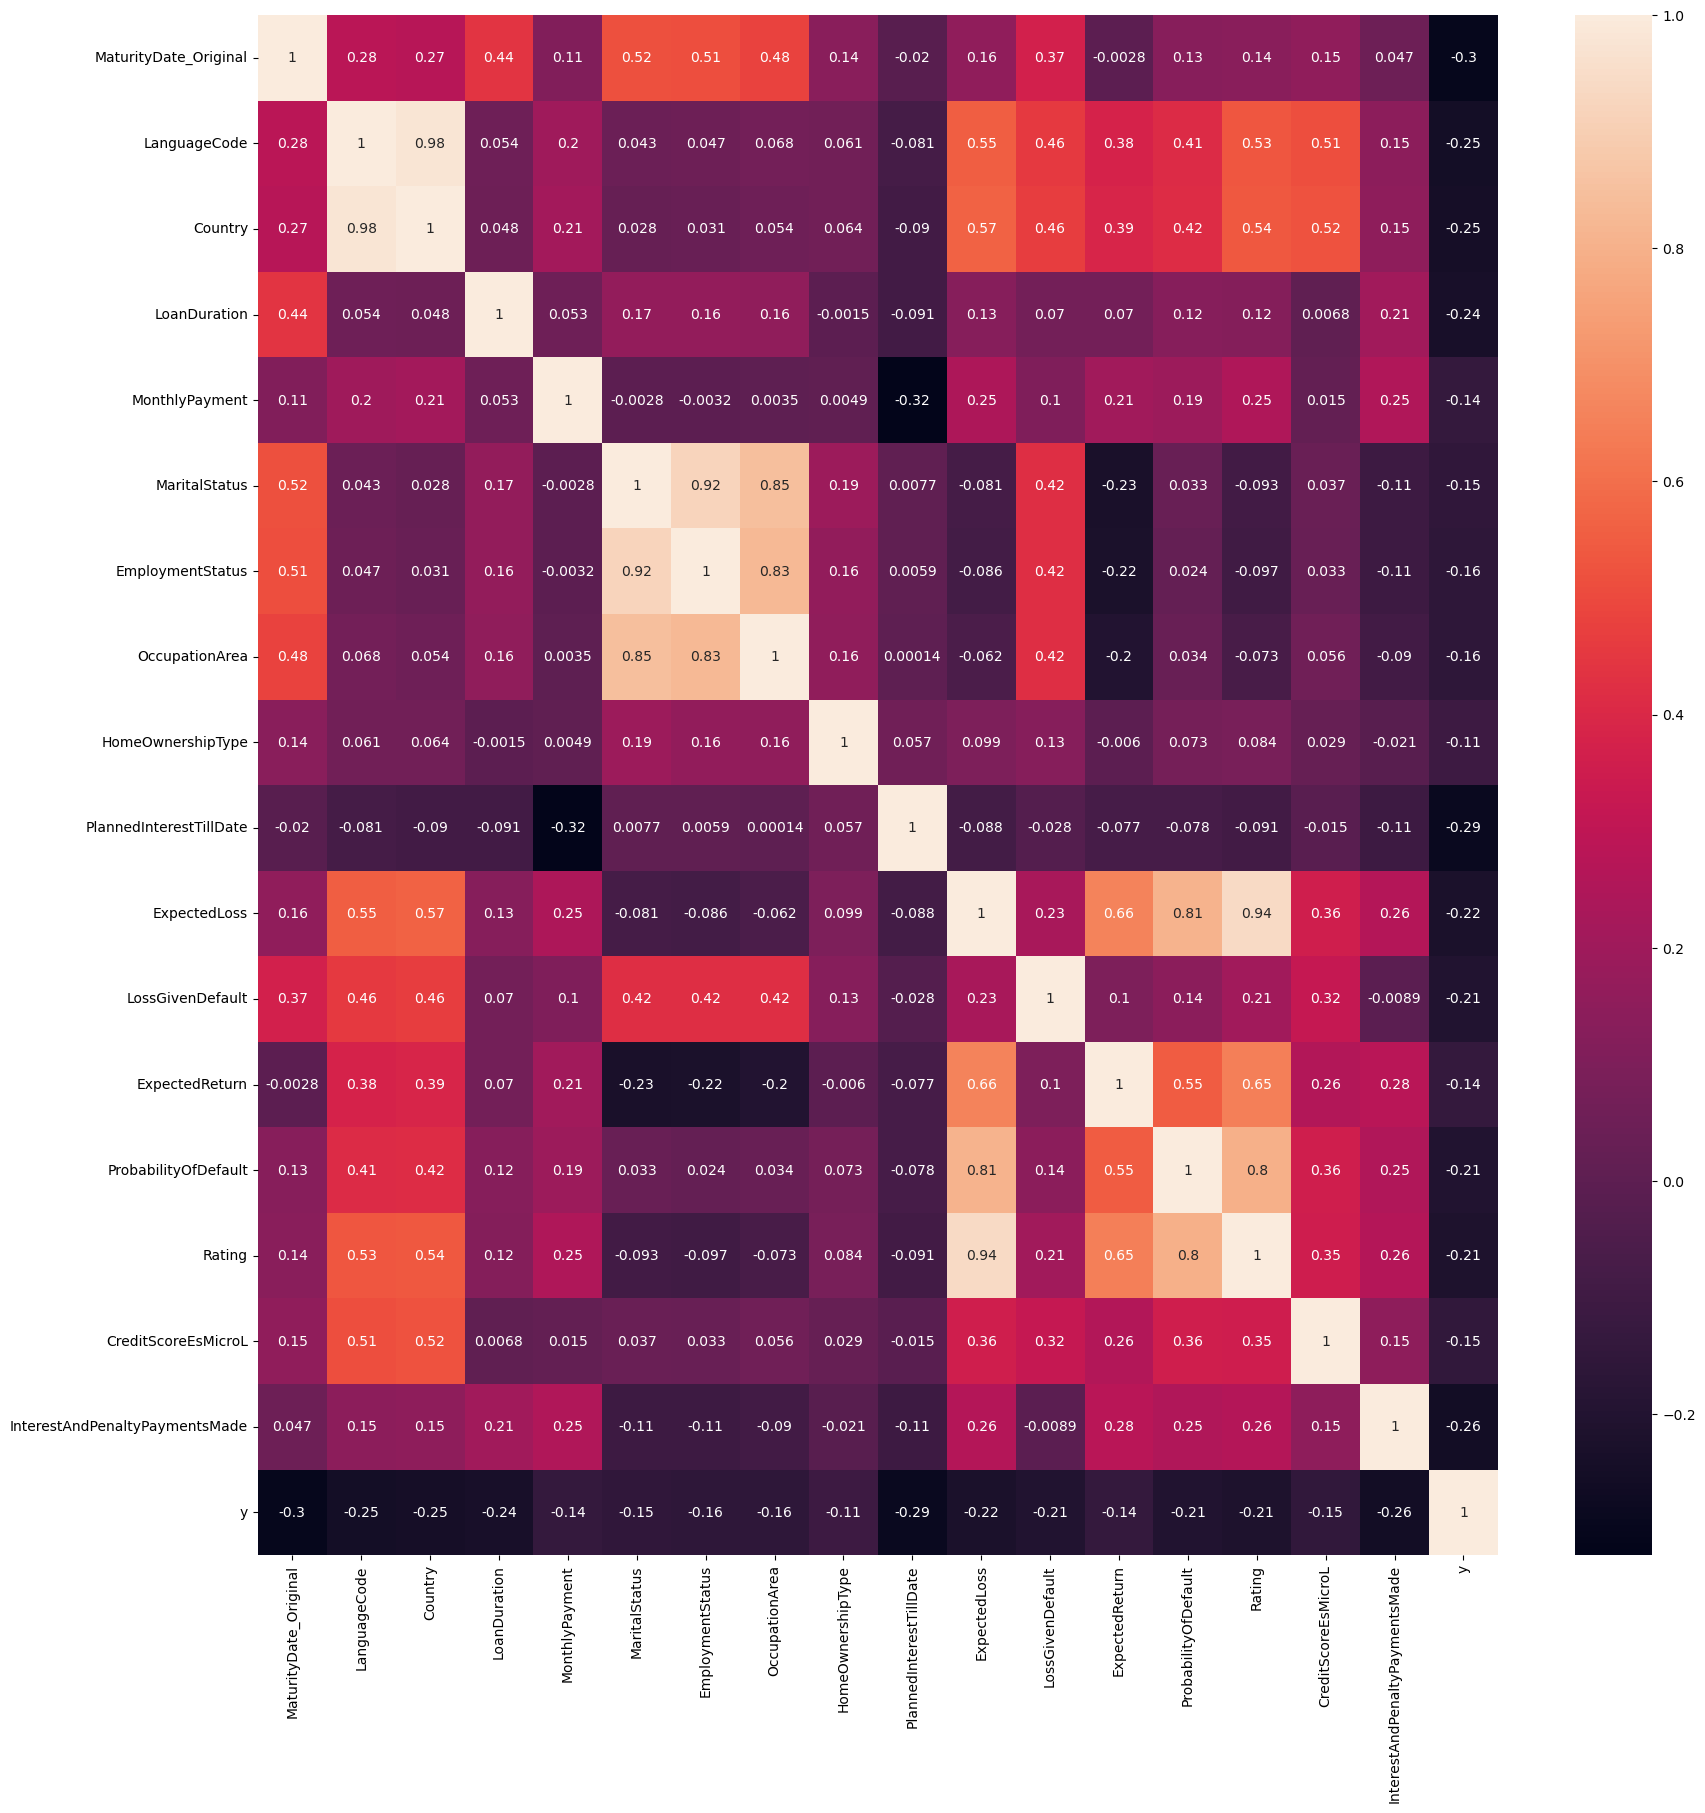

In [104]:
# Plot correlation matrix using Pearson coefficient
plt.figure(figsize=(20,20))
sns.heatmap(dulieuktl1_train.corr(method='pearson'), annot=True);

=> It is obvious that some pairs of 2 variables have such a high correlation coefficient (> 0.7) so I carry on removing some variables that have less significance in last steps.

In [106]:
dulieuktl1_train = dulieuktl1_train.drop(columns=['LanguageCode','MaritalStatus','ExpectedLoss','ProbabilityOfDefault','Rating'])

In [ ]:
4.2. Stepwise regression

#Note: Now Scikit-learn indeed does not support stepwise regression. So I must use just Recursive feature elimination, i.e an example of backward feature elimination in which we essentially first fit our model using all the features in a given set, then progressively one by one we remove the least significant features, each time re-fitting, until we are left with the desired number of features, which is set by the parameter n_features_to_select.

In [57]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
rfe = RFE(logreg, n_features_to_select=5, step=1)
rfe = rfe.fit(dulieuktl1_train.drop('y',axis =1), y_train.ravel())
print(rfe.support_)
print(rfe.ranking_)

[ True False  True False False False  True False False False False False
  True False False False False False False False  True]
[ 1 12  1  5  4 11  1  2 10  9  3  8  1 16  6 14  7 15 13 17  1]


In [58]:
selected = rfe.ranking_

In [59]:
selectedvar = np.where(selected == 1)

In [60]:
dulieuktl1_train.columns.values[selectedvar]

array(['MaturityDate_Original', 'Country', 'LoanDuration',
       'PlannedInterestTillDate', 'InterestAndPenaltyPaymentsMade'],
      dtype=object)

In [61]:
df8 = smf.logit(formula = 'y ~ InterestAndPenaltyPaymentsMade + Country + LoanDuration +  PlannedInterestTillDate + MaturityDate_Original ', data = dulieuktl1_train).fit()
df8.summary()

Optimization terminated successfully.
         Current function value: 0.510371
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:               162315
Model:                          Logit   Df Residuals:                   162309
Method:                           MLE   Df Model:                            5
Date:                Mon, 05 Jun 2023   Pseudo R-squ.:                  0.2490
Time:                        12:13:57   Log-Likelihood:                -82841.
converged:                       True   LL-Null:                   -1.1031e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
==================================================================================================
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                         -0.4589      0.006    -73.729      0.000      -0.471      -0.447
InterestAndPenaltyPaymentsMade    -0.0068   7.06e-05    -95.906      0.000      -0.007      -0.007
Country                           -0.0047   6.32e-05    -74.404      0.000      -0.005      -0.005
LoanDuration                      -0.0040   8.13e-05    -49.490      0.000      -0.004      -0.004
PlannedInterestTillDate           -0.0089   6.73e-05   -132.480      0.000      -0.009      -0.009
MaturityDate_Original             -0.0059   8.33e-05    -70.524      0.000      -0.006      -0.006
==================================================================================================
"""

In [ ]:
5. Model validation

In [65]:
SelectedVarName = dulieuktl1_train.columns.values[selectedvar]

In [66]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import train_test_split

logreg = LogisticRegression()
logreg.fit(dulieuktl1_train[SelectedVarName], y_train)


LogisticRegression()

In [67]:
y_pred = logreg.predict(dulieuktl1_test[SelectedVarName])
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[23508,     0],
       [17071,     0]], dtype=int64)

=> There are 23508 non-defaulters were predicted correctly, though all 17071 defaulters were precdited as good customers (incorrectly predicted).

In [72]:
np.where(y_pred == 1)

(array([], dtype=int64),)

In [73]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))


Accuracy: 0.5793144237167007


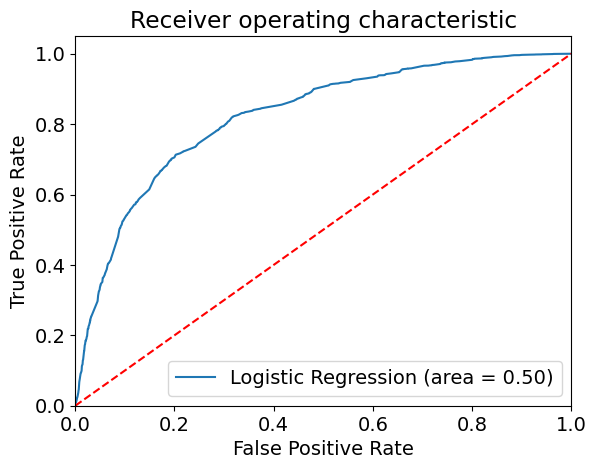

In [74]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt 
plt.rc("font", size=14)
logit_roc_auc = roc_auc_score(y_test, logreg.predict(dulieuktl1_test[SelectedVarName]))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(dulieuktl1_test[SelectedVarName])[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()